## **What will this chatbot solve?**

- **Research Paper Query Engine** - This feature cuts down the time you might spend searching through endless academic papers, helping you quickly get the information about the data science concepts that's most relevant to your project.

- **Graph Paper Relationship Engine** - This tool helps you see the connections between different research studies.

# **0. Loading the Gemma model**

In [ ]:
# %%capture
# # !mamba install cudatoolkit xformers bitsandbytes pytorch pytorch-cuda=11.8 \
# #     -c pytorch -c nvidia -c xformers -c conda-forge -y
# !pip install "unsloth[kaggle] @ git+https://github.com/unslothai/unsloth.git"
# !pip uninstall datasets -y
# !pip install datasets

# import os
# os.environ["WANDB_DISABLED"] = "true"


In [ ]:
# %%capture
# !pip install xformers==0.0.25.post1
# !pip install bitsandbytes
# !pip install llama-index
# !pip install llama-index-embeddings-huggingface
# !pip install llama-index-vector-stores-chroma
# !pip install chromadb
# !pip install llama-index-llms-huggingface
# !pip install llama-index-llms-groq
# !pip install sentence-transformers
# !pip install pyvis==0.3.1
# !pip install torch=2.2.2
# !pip install -U wikipedia-api

In [ ]:
# from unsloth import FastLanguageModel
# import torch
# max_seq_length = 1024 # Choose any! We auto support RoPE Scaling internally!
# dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
# load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# # 4bit pre quantized models we support for 4x faster downloading + no OOMs.
# fourbit_models = [
#     "unsloth/mistral-7b-bnb-4bit",
#     "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
#     "unsloth/llama-2-7b-bnb-4bit",
#     "unsloth/gemma-7b-bnb-4bit",
#     "unsloth/gemma-7b-it-bnb-4bit", # Instruct version of Gemma 7b
#     "unsloth/gemma-2b-bnb-4bit",
#     "unsloth/gemma-2b-it-bnb-4bit", # Instruct version of Gemma 2b
# ] # More models at https://huggingface.co/unsloth

# model, tokenizer = FastLanguageModel.from_pretrained(
#     model_name = "unsloth/gemma-7b-bnb-4bit", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
#     max_seq_length = max_seq_length,
#     dtype = dtype,
#     load_in_4bit = load_in_4bit,
#     # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
# )

In [ ]:
# from llama_index.llms.huggingface import HuggingFaceLLM

# from unsloth import FastLanguageModel
# import torch
# max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
# dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+

# gemma_llm = HuggingFaceLLM(model=model, tokenizer=tokenizer, context_window=8192, max_new_tokens=max_seq_length)

Let's test the `gemma_llm`

In [ ]:
# Markdown(gemma_llm.complete("What is data science?").text)

# **1. Scientific Research Assistant**

In this section, we're focusing on creating the first part of our chatbot: a tool that can search through a huge number of research papers on arXiv. The key to this tool is using embeddings, taken from paper abstracts. Think of these as unique IDs that sum up what each paper is about.

When you ask the chatbot something, it uses these embeddings to look through the abstracts and find papers that really match what you're looking for, not just by keywords, but by the actual ideas and concepts you're interested in. This is more about understanding the meaning of your question and finding papers that really match.

We'll go through everything: picking the right papers from arXiv, getting the abstracts ready, and choosing a way to turn these abstracts into embeddings. Then, we'll set up a smart search that can quickly find the best matches when you ask a question.

## **1.1 Data Preprocessing**

In [ ]:
# https://www.kaggle.com/code/matthewmaddock/nlp-arxiv-dataset-transformers-and-umap

# This takes about 1 minute.
import json
import pandas as pd

cols = ['id', 'title', 'abstract', 'categories']
data = []
file_name = '/home/mahita/fyp/input/arxiv-metadata-oai-snapshot.json'


with open(file_name, encoding='latin-1') as f:
    for line in f:
        doc = json.loads(line)
        lst = [doc['id'], doc['title'], doc['abstract'], doc['categories']]
        data.append(lst)

df_data = pd.DataFrame(data=data, columns=cols)

print(df_data.shape)

df_data.head()

(2459562, 4)


,id,title,abstract,categories
0,0704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,hep-ph
1,0704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",math.CO cs.CG
2,0704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,physics.gen-ph
3,0704.0004,A determinant of Stirling cycle numbers counts...,We show that a determinant of Stirling cycle...,math.CO
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,In this paper we show how to compute the $\L...,math.CA math.FA


There are a total of almost 2,5M papers on arxiv, that's too much! However, not all of them are about AI, so let's narrow down to the topics we're interested in.

In [ ]:
# import pandas as pd

# topics = ['cs.AI', 'cs.CV', 'cs.IR', 'cs.LG', 'cs.CL']

# # Create a regular expression pattern that matches any of the topics
# # The pattern will look like 'cs.AI|cs.CV|cs.IR|cs.LG|cs.CL'
# pattern = '|'.join(topics)

# # Filter the DataFrame to include rows where the 'categories' column contains any of the topics
# # The na=False parameter makes sure that NaN values are treated as False
# df_filtered = df_data[df_data['categories'].str.contains(pattern, na=False)]

# # Display the filtered DataFrame
# df_filtered

Great! Now we down to about 330K papers. Now, let's clean the text.

In [ ]:
# df_filtered.iloc[110]

In [ ]:
def clean_text(x):

    # Replace newline characters with a space
    new_text = " ".join([c.strip() for c in x.replace("\n", "").split()])
    # Remove leading and trailing spaces
    new_text = new_text.strip()

    return new_text

df_data['title'] = df_data['title'].apply(clean_text)
df_data['abstract'] = df_data['abstract'].apply(clean_text)

df_data['prepared_text'] = df_data['title'] + '\n ' + df_data['abstract']
df_data.head()

,id,title,abstract,categories,prepared_text
0,0704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturbati...,hep-ph,Calculation of prompt diphoton production cros...
1,0704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-pe...",math.CO cs.CG,Sparsity-certifying Graph Decompositions\n We ...
2,0704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is describe...,physics.gen-ph,The evolution of the Earth-Moon system based o...
3,0704.0004,A determinant of Stirling cycle numbers counts...,We show that a determinant of Stirling cycle n...,math.CO,A determinant of Stirling cycle numbers counts...
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,In this paper we show how to compute the $\Lam...,math.CA math.FA,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...


In [ ]:
# from llama_index.core import Document

# arxiv_documents = [Document(text=prepared_text, doc_id=id) for prepared_text,id in list(zip(df_data['prepared_text'], df_data['id']))]

## **1.2 Creating Index**

The `VectorStoreIndex` is by far the most frequently used type of Index in llamaindex. This class takes your Documents and splits them up into Nodes. Then, it creates `vector_embeddings` of the text of every node. But what is `vector_embedding`?

Vector embeddings are like turning the essence of your words into a mathematical sketch. Imagine every idea or concept in your text getting its unique numerical fingerprint. This is handy because even if two snippets of text use different words, if they're sharing the same idea, their numerical sketches—or embeddings—will be close neighbors in the numerical space. This magic is done using tools known as embedding models.

Choosing the right embedding model is crucial. It's like picking the right artist to paint your portrait; you want the one who captures you best. A great place to start is the MTEB leaderboard, where the crème de la crème of embedding models are ranked. As we have quite a large dataset, the model size matters, we don't want to wait all day for the model to extract all the vector embeddings. When I last checked, the `BAAI/bge-small-en-v1.5` model was leading the pack, especially considering its size. It could be a solid choice if you're diving into the world of text embeddings.


Note: *The embedding process may take a considerable amount of time. To save time, I have precomputed it. If you wish to execute the process from the beginning, uncomment the following code.*

In [ ]:
# from llama_index.core import VectorStoreIndex
# from llama_index.embeddings.huggingface import HuggingFaceEmbedding
# from llama_index.core import Settings
# import chromadb
# import torch
# from llama_index.vector_stores.chroma import ChromaVectorStore
# from llama_index.core import StorageContext

# Settings.llm = None
# # Create embed model
# device_type = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5", cache_folder="../models", device=device_type)

Great! Now we have to find somewhere to store all of the embeddings extracted by the model, and that's why we need a `vector store`. There are many to choose from, in this tutorial, I will choose the `chroma` vector store

In [ ]:
# chroma_client = chromadb.PersistentClient(path="../DB/arxiv")
# chroma_collection = chroma_client.get_or_create_collection("gemma_assistant_arxiv_papers")


# # Create vector store
# vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
# storage_context = StorageContext.from_defaults(vector_store=vector_store)

Note: This part takes quite a lot of time! So I precomputed the embedding and store them into chroma db

In [ ]:
# index = VectorStoreIndex.from_documents(
#     arxiv_documents, storage_context=storage_context, embed_model=embed_model, show_progress=True
# )

## **1.3 Loading from arxiv vector store**

Now, let's load the precomputed embeddings!

In [ ]:
# !cp -r /kaggle/input/gemma-assistant-db .

In [ ]:
from llama_index.core import VectorStoreIndex, Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext
import torch

In [ ]:
Settings.llm = None # Set this to none to make the index only do retrieval
# device_type = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5", cache_folder="../models", device=device_type) # must be the same as the previous stage

embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5") # must be the same as the previous stage

LLM is explicitly disabled. Using MockLLM.


/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/opt/conda/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always r

In [ ]:
chroma_client = chromadb.PersistentClient(path="/home/mahita/fyp/input/arxiv")
chroma_collection = chroma_client.get_or_create_collection("gemma_assistant_arxiv_papers")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
# load the vectorstore
storage_context = StorageContext.from_defaults(vector_store=vector_store)
paper_index = VectorStoreIndex.from_vector_store(vector_store, storage_context=storage_context, embed_model=embed_model)

In [ ]:
paper_query_engine = paper_index.as_query_engine(
    similarity_top_k=10
)

In [ ]:
print(paper_query_engine.query("What are some papers about integrating social data analytics in fake news detection?"))

Context information is below.
---------------------
fake news detection on social media: a data mining perspective
 Social media for news consumption is a double-edged sword. On the one hand,its low cost, easy access, and rapid dissemination of information lead peopleto seek out and consume news from social media. On the other hand, it enablesthe wide spread of "fake news", i.e., low quality news with intentionally falseinformation. The extensive spread of fake news has the potential for extremelynegative impacts on individuals and society. Therefore, fake news detection onsocial media has recently become an emerging research that is attractingtremendous attention. Fake news detection on social media presents uniquecharacteristics and challenges that make existing detection algorithms fromtraditional news media ineffective or not applicable. First, fake news isintentionally written to mislead readers to believe false information, whichmakes it difficult and nontrivial to detect based o

## **1.4 Prompt Engineering**

Prompting is essential for large language models (LLMs) as it guides their responses to be more relevant and contextually appropriate. A well-crafted prompt directs the LLM to focus on specific tasks, ensuring that the output is not only precise but also useful for the user. This specificity is crucial in complex domains where accuracy and detail are key. Effective prompting helps maximize the utility of LLMs by tailoring their vast language capabilities to specific user needs.

Let's take a look at llama-index default prompt for the query engine.

In [ ]:
prompts_dict = paper_query_engine.get_prompts()
print(list(prompts_dict.keys()))

['response_synthesizer:text_qa_template', 'response_synthesizer:refine_template']


In [ ]:
print(prompts_dict['response_synthesizer:text_qa_template'].conditionals[0][1].message_templates[0].content)

You are an expert Q&A system that is trusted around the world.
Always answer the query using the provided context information, and not prior knowledge.
Some rules to follow:
1. Never directly reference the given context in your answer.
2. Avoid statements like 'Based on the context, ...' or 'The context information ...' or anything along those lines.


**This is the system prompt. Now look at the user prompt**

In [ ]:
print(prompts_dict['response_synthesizer:text_qa_template'].conditionals[0][1].message_templates[1].content)

Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {query_str}
Answer: 


**The default prompts given by llama index is good in general tasks, however we can tailored it to make it specific for our task, which is searching for Data Science papers. Here is how to do it:**

In [ ]:
from llama_index.core import ChatPromptTemplate, PromptTemplate
from llama_index.core.llms import ChatMessage, MessageRole

system_prompt = """
You are an expert research assistant specializing in machine learning and artificial intelligence.
Your task involves processing a collection of recent research paper abstracts. Perform the following:

1. Provide a coherent and comprehensive summary of these abstracts tailored to the user's specific query.
2. Identify and summarize the key themes, methodologies, and implications of the research findings, highlighting any significant trends or innovations.
"""

user_prompt = """
Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {query_str}
Answer:
"""

message_template = [
    ChatMessage(content=system_prompt, role=MessageRole.SYSTEM),
    ChatMessage(content=user_prompt, role=MessageRole.USER)
]
prompt_template = PromptTemplate(user_prompt)

In [ ]:
# paper_query_engine = paper_index.as_query_engine(
#     llm=gemma_llm,
#     similarity_top_k=3,
# )


paper_query_engine.update_prompts(
    {"response_synthesizer:text_qa_template": prompt_template}
)

In [ ]:
for retrieve_result in paper_query_engine.retrieve("What are some research about video diffusion"):
    print(retrieve_result.text)

a survey on video diffusion models
 The recent wave of AI-generated content (AIGC) has witnessed substantialsuccess in computer vision, with the diffusion model playing a crucial role inthis achievement. Due to their impressive generative capabilities, diffusionmodels are gradually superseding methods based on GANs and auto-regressiveTransformers, demonstrating exceptional performance not only in imagegeneration and editing, but also in the realm of video-related research.However, existing surveys mainly focus on diffusion models in the context ofimage generation, with few up-to-date reviews on their application in the videodomain. To address this gap, this paper presents a comprehensive review ofvideo diffusion models in the AIGC era. Specifically, we begin with a conciseintroduction to the fundamentals and evolution of diffusion models.Subsequently, we present an overview of research on diffusion models in thevideo domain, categorizing the work into three key areas: video generation,

**Let's test our prompt!**

In [ ]:
from IPython.display import Markdown

Markdown(paper_query_engine.query("What are some papers about integrating social data analytics in fake news detection?").response)

The provided text does not contain any information regarding papers that discuss integrating social data analytics in fake news detection, so I am unable to answer this query from the given context.

## **1.5 Gemma Inference at super speed**

Inferencing LLM is super slow, especially running LLM on free infrastructure like kaggle. Kaggle is great, however it could be too slow for complex RAG apps. In this notebook, I will demonstrate the use of the Groq API service for Gemma inference. Here's why I've chosen Groq for this task:

- Groq offers incredibly fast inference speeds, approximately 700-800 tokens per second. This high performance allows for the execution of complex RAG pipelines without concerns about speed limitations.

- Enhanced performance: On platforms like Kaggle, we are restricted to using only the quantized Gemma model, which yields poorer and less consistent results. Utilizing an API service like Groq simplifies the process and enhances the outcomes.

- Generous free tier: Groq provides a substantial number of requests on its free tier, making it an accessible option for extensive testing and development.

In [ ]:
from llama_index.llms.groq import Groq
# from kaggle_secrets import UserSecretsClient
# from llama_index.core import Settings

secret_label = 'groq'
groq_token = "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"


groq_llm = Groq("gemma-7b-it", api_key=groq_token)
llm = groq_llm
Settings.llm = groq_llm

In [ ]:
from IPython.display import Markdown

Markdown(groq_llm.complete("What is linear regression?").text)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


**Linear regression** is a statistical method used to model the relationship between a dependent variable and one or more independent variables. It is a simple and widely used technique for **predictive modeling** and **understanding the influence** of independent variables on the dependent variable.

**How it works:**

- Linear regression finds a straight line that best fits the data points.
- The line is represented by the equation:

$$y = a + bx$$

Where:

- **y** is the dependent variable
- **a** is the intercept (the value of y when x is 0)
- **b** is the slope (the change in y for a one-unit change in x)

**Assumptions of linear regression:**

- Linearity: The relationship between the dependent and independent variables is straight.
- Homoscedasticity: The variance of the residuals (the difference between the observed values and the predicted values) is constant.
- Normality: The residuals are normally distributed.
- Independence: The observations are independent of each other.

**Process:**

1. Data collection and exploration
2. Model fitting: The linear equation is estimated using least squares method.
3. Model evaluation: The goodness of fit and significance of the coefficients are assessed.
4. Interpretation: The coefficients and the overall model are interpreted to understand the influence of the independent variables on the dependent variable.

**Applications of linear regression:**

- **Predictive modeling:** Forecasting future values based on historical data.
- **Quality control:** Identifying factors that influence product quality.
- **Marketing and sales:** Understanding customer behavior and market trends.
- **Finance:** Modeling financial performance and risk assessment.
- **Engineering:** Optimizing processes and designing systems.

**Advantages of linear regression:**

- Simple and easy to understand.
- Widely applicable.
- Provides insights into the relationship between variables.
- Relatively easy to implement.

**Disadvantages of linear regression:**

- Not suitable for non-linear relationships.
- Can be biased if assumptions are not met.
- May not capture complex interactions between variables.

In [ ]:
paper_query_engine = paper_index.as_query_engine(
    similarity_top_k=5,
    llm=groq_llm
)

In [ ]:
Markdown(paper_query_engine.query("What are some research about video diffusion?").response)

The provided text contains several research papers related to video diffusion models. Some of the highlighted research topics include:

- **Sample Replication in Video Diffusion Models:** This paper investigates the phenomenon of sample replication in video diffusion models, identifying strategies to mitigate this issue.


- **Stable Video Diffusion:** This paper proposes Stable Video Diffusion, a latent video diffusion model for high-resolution video generation, focusing on data curation and training strategies.


- **VidProM:** This paper introduces VidProM, a large-scale dataset of text-to-video prompts and generated videos, designed to aid the development of text-to-video diffusion models.


- **Video Diffusion Models:** This paper proposes a diffusion model for video generation, addressing the challenges of generating temporally coherent and high-fidelity videos.

# **2. Graph-based paper relationship search**

In this section, we delve into constructing a knowledge graph that illustrates the relationships between papers. This graph can be used for interactive visualization and searching relationships between papers (e.g., 'How is paper A related to paper B?') or to find specific relationships within a paper (e.g., 'What works did paper A build upon?'). Moreover, understanding the impact of a paper typically requires examining not just the paper itself but also the works that cite it. This graph serves as a tool for this purpose; it not only displays the papers that cited a specific paper but also explains WHY they cited it. The steps for constructing this knowledge graph are as follows:

- Step 1: arXiv Data Extraction: The process starts with academic papers from the arXiv database, which undergo OCR (Optical Character Recognition) and PDF parsing, which organizes the content into structured data such as the title, abstract, sections, and references of the papers.

- Step 2: Text Splitter: The text in each section is then processed by a Text Splitter, which split the paper section into smaller chunks, which could be easier for LLMs to process.  

- Step 3 GPT-3.5 Processing: Gemma couldn't generate the knowledge graph out-of-the-box. So we need knowledge distillation from a bigger model, which I choose GPT-3.5. The structured data is passed to GPT-3.5 to extract citation relationships, such as "Data Source", "Extension", or "Theoretical Foundation", etc. Each relationship is paired with a dense explanation. I extracted a total of ~300 papers, which cost around 4$.

- Step 4 Training Gemma - 7B: The distilled knowledge data are then used to train Gemma-7b. Then I use this model to generate citation relationships for as many papers as I can. In total, I extracted 7k papers, with around 150K triplets! Crazy!!

- Step 5 Graph Store: Finally, a Graph Store is created containing 7K papers and 586K triplets. This could then be used for searching relationships or visualization.


## **2.0 Extracting Data + Knowledge distillation**

**Knowledge distillation** involves training a smaller, less complex model (termed the "student") to mimic the behavior of a larger, more intricate model (referred to as the "teacher"). The objective is to impart the teacher model's knowledge to the student model so that the student can perform comparably but more efficiently and with reduced computational demands. To achieve this, the student model learns not only from the direct outputs, such as class labels in classification tasks, but also from the softer, indirect outputs like the probability distributions or the feature representations that the teacher model produces. This technique is especially valuable for deploying advanced AI models on devices with constrained computational resources, such as smartphones or embedded systems.

In this project, I initially utilized OCR and PDF reader tools to extract textual information from PDF files. The extracted text was then segmented and input into GPT-3.5 to create a dataset for distilling knowledge into Gemma-7B. This dataset is accessible here: [citation data](https://www.kaggle.com/datasets/bachngoh/citation-generation-train)

Here are some training samples:
```json

{
            "Input": "Additionally, generalizing over objects, actions and events allow users to make predictions of upcoming Effects even for unseen events (Radinsky, Davidovich, and Markovitch 2012). Therefore, in our work, we condense our graphs by grouping nodes that refer to the same topic together using previous topic modelling solutions (Sia, Dalmia, and Mielke 2020;Zhang et al. 2022)."
            "Output":[
    {
        "Citation": "(Radinsky, Davidovich, and Markovitch 2012)"
        "Category": "Theoretical Foundation"
        "Explanation": "The cited work establishes the importance of generalizing over objects, actions, and events to make predictions, which forms the theoretical basis for the approach taken in the citing paper."
    },
    {
        "Citation":"(Sia, Dalmia, and Mielke 2020; Zhang et al. 2022)"
        "Category":"Methodological Basis"
        "Explanation":"The cited works introduce the method of condensing graphs by grouping nodes based on topic modeling solutions, which is adopted by the citing paper to structure its analysis."}]
}

```

```json

{
        "Input":"The proposed GIFT was implemented into three PLMs. • BERT (Devlin et al., 2019) was pre-trained to learn universal language representations on a large amount of general corpora with the self-supervised tasks of MLM and NSP. • SA-BERT (Gu et al., 2020) added speaker embeddings and further pre-trained BERT on a domain-specific corpus to incorporate domain knowledge. We re-implemented SA-BERT on the same pre-training corpus used in this paper to ensure fair comparison. • MPC-BERT (Gu et al., 2021) was pre-trained with two major types of self-supervised tasks for modeling interlocutor structures and utterance semantics in a unified framework. (2016). For models with GIFT, numbers marked with ‡ denoted larger performance improvement or less performance drop compared with the corresponding models without GIFT."
        "Output":[
    {
        "Citation":"(Devlin et al., 2019)"
        "Category":"Methodological Basis"
        "Explanation":"The cited work, BERT, serves as the basis for pre-training language representations using self-supervised tasks of MLM and NSP, which is adopted by the citing paper for implementing the proposed GIFT into PLMs."
    }
    {
        "Citation":"(Gu et al., 2020)"
        "Category":"Extension or Continuation"
        "Explanation":"SA-BERT, as cited, extends the pre-training of BERT by incorporating speaker embeddings and domain-specific knowledge, which is further explored and re-implemented in the citing paper for a fair comparison."
    }
    {
        "Citation":"(Gu et al., 2021)"
        "Category":"Extension or Continuation"
        "Explanation":"MPC-BERT, referenced in the text, extends the pre-training of BERT by incorporating self-supervised tasks for modeling interlocutor structures and utterance semantics, which is further explored in the citing paper for enhancing language representations."}]
}

```

## **2.1 Download pre-extracted citation data**

In [ ]:
from datasets import load_dataset

parsed_article = load_dataset("BachNgoH/ParsedArxivPapers")['train']

Generating train split:   0%|          | 0/19454 [00:00<?, ? examples/s]

In [ ]:
import datasets
datasets.__version__

'2.19.1'

In [ ]:
parsed_article = parsed_article.to_list()

In [ ]:
import json

for article in parsed_article:
    if article['citation_data'] != None:
        article['citation_data'] = json.loads(article['citation_data'])

In [ ]:
# parsed_article[1]['citation_data']

In [ ]:
len(parsed_article)

19454

Let's see the number of annotated papers for now!

In [ ]:
annotated_article = [x for x in parsed_article if x['citation_data'] is not None]

In [ ]:
print("Annotated Papers: ", len(annotated_article))

Annotated Papers:  7243


In [ ]:
# annotated_article[1]['citation_data']

## **2.2 Parsing generated data**

From my observation, there are 2 main citation styles in AI papers, Author-year style and Numeric style:

Example of Author-year style:
- (Bassignana and Plank, 2022a)
- (Liu et al., 2021)
- (Köksal and Özgür, 2020)

Example of Numeric style:
- [1], [2], [3]
- [2, 56, 67]
- [7 - 9]

Therefore, we need different strategy to handle each style of citation

### **2.2.1 Handle Author-Year citation style**

Handling this citation style can be quite frustrating. Initially, we must separate combined citations like (Liu et al., 2021; Littell et al., 201) into individual entries. Then, we need to identify the first author and publication year. Subsequently, we have to locate the corresponding reference within our reference list based on the author's name and publication year.

In [ ]:
# Parse annotated articles
import re

# Function to normalize author names for comparison
def normalize_author_name(name):
    # Convert to lowercase and remove middle initials
    name = name.lower()
    name = re.sub(r"\s+[a-z]\.", "", name)  # Remove middle initials
    return name


citation_names = [c['Citation'] for c in annotated_article[1]['citation_data']]
citation_names

['(Castillo et al., 2015)',
 '(Castillo et al., 2017)',
 '(Castillo et al., , 2017)',
 '(Mihalcea and Tarau, 2004)',
 '(Hassan and Banea, 2006)',
 '(Rousseau et al., 2015)',
 '(Castillo et al., 2015)',
 '(Arora et al., 2009)',
 '(Joshi and Rosé, 2009)',
 '(Dozat and Manning, 2016)',
 '(Yuan et al., 2021)',
 '(Yao et al., 2019)',
 '(Liu et al., 2020)',
 '(Ragesh et al., 2021)',
 '(Ding et al., 2020)',
 '(Huang et al., 2019a)',
 '(Qian et al., 2019)',
 '(Li et al., 2015;Cho et al., 2014)',
 '(Nikolentzos et al., 2020)',
 '(Gu et al., 2023)',
 '(Galke and Scherp, 2022)',
 '(Hassan and Banea, 2006)',
 '(Castillo et al., 2015)',
 '(Huang et al., 2019b)',
 '(Devlin et al., 2018)',
 '(Beltagy et al., 2020)',
 '(Grano et al., 2017)',
 '(Zhang et al., 2015)',
 '(Maas et al., 2011)',
 '(Greene and Cunningham, 2006)',
 '(Kiesel et al., 2018)',
 '(Kipf and Welling 2016)',
 '(Xu et al. 2018)',
 '(Velickovic et al. 2017)',
 '(see Appendix E)',
 '(default parameter settings in the original implementa

In [ ]:
# Refined function to identify and normalize the first author from a citation
def identify_and_normalize_first_author(citation_authors):
    # Check for 'et al.' and 'and' to find the first author
    if 'et al.' in citation_authors:
        first_author = citation_authors.split('et al.')[0].strip()
    elif ' and ' in citation_authors:
        first_author = citation_authors.rsplit(' and ', 1)[0].split(',')[0].strip()
    else:
        first_author = citation_authors.split(',')[0].strip()
    # Normalize the first author's name for comparison
    return first_author.lower()


# Function to split and parse citations in cases of citation
# like (Culotta and Sorensen 2004; Bunescu and Mooney 2005; Ittoo and Bouma 2013)
def split_and_parse_citation(citation):

    # Remove outer parentheses
    citation = citation.strip("()")
    # Split on semicolon if it's present, indicating multiple citations within one
    if ';' in citation:
        sub_citations = citation.split(';')
    else:
        sub_citations = [citation]

    # Parse each sub-citation for author names and year
    for sub_citation in sub_citations:
        # Splitting based on the last occurrence of space which is assumed to be before the year
        *authors, year = sub_citation.rsplit(' ', 1)
        authors = ' '.join(authors)  # Joining back the authors in case there are multiple names
        parsed_citation = {'Author': identify_and_normalize_first_author(authors), 'Year': year}

    return parsed_citation

In [ ]:
references = annotated_article[1]['references'][:5]
references

[{'authors': 'Shilpa Arora; Mahesh Joshi; Carolyn Rosé',
  'journal': '',
  'ref_id': 'b0',
  'title': 'Identifying types of claims in online customer reviews',
  'year': '2009'},
 {'authors': 'Iz Beltagy; Matthew E Peters; Arman Cohan',
  'journal': '',
  'ref_id': 'b1',
  'title': 'Longformer: The long-document transformer',
  'year': '2020'},
 {'authors': 'Esteban Castillo; Ofelia Cervantes; Darnes Vilari;  David',
  'journal': 'International Journal of Computer Applications',
  'ref_id': 'b2',
  'title': 'Author verification using a graphbased representation',
  'year': '2015'},
 {'authors': 'Esteban Castillo; Ofelia Cervantes; Darnes Vilarino',
  'journal': 'Computación y Sistemas',
  'ref_id': 'b3',
  'title': 'Text analysis using different graph-based representations',
  'year': '2017'},
 {'authors': 'Kyunghyun Cho; Bart Van Merriënboer; Caglar Gulcehre; Dzmitry Bahdanau; Fethi Bougares; Holger Schwenk; Yoshua Bengio',
  'journal': '',
  'ref_id': 'b4',
  'title': 'Learning phra

In [ ]:
# Function to normalize and extract the first author's name
def get_first_author(authors_str):
    first_author = authors_str.split(';')[0].strip()
    # Normalize the first author's name for comparison
    return first_author.lower()

# Generalized regular expression for detecting years in various date formats and standalone years

# Function to detect various year patterns and extract the year
def extract_years(string):
    general_year_pattern = re.compile(r'(?:\b|\D)(\d{4})(?:\b|\D)')
    # Find all matches for the general year pattern

    matches = general_year_pattern.findall(string)
    # Add all unique years found in this string
    year = matches[0] if matches else None
    return year

# Function to match citations with references
def match_citations_with_references(citation, references):
    match = None
    citation_first_author = citation['Author']
    citation_year = citation['Year'].strip()
    for ref in references:
        ref_first_author = get_first_author(ref['authors'])
        ref_year = extract_years(ref['year']) if ref['year'] is not None else None
        # Check for match by first author and year
        if citation_first_author in ref_first_author: #and (citation_year == ref_year or ref_year is None):
            match = {
                'ref_id': ref['ref_id']
            }
    return match

In [ ]:
# test with the first sample
for citation in annotated_article[1]['citation_data']:
    parsed_name = split_and_parse_citation(citation['Citation'])
    match = match_citations_with_references(parsed_name, references)
    citation['ref_id'] = match['ref_id'] if match else None

Now we need to group the citation data by ref_id

In [ ]:
annotated_article[1]['citation_data']

[{'Category': 'Methodological Basis',
  'Citation': '(Castillo et al., 2015)',
  'Explanation': 'The cited work provides a foundation for the use of graphs in text classification tasks, as it discusses the applicability and effectiveness of graphs in broader settings.',
  'ref_id': 'b3'},
 {'Category': 'Extension or Continuation',
  'Citation': '(Castillo et al., 2017)',
  'Explanation': 'The cited work is a continuation of the research on graph representations in text classification, as it further explores the use of graphs in more diverse scenarios.',
  'ref_id': 'b3'},
 {'Category': 'Data Source',
  'Citation': '(Castillo et al., , 2017)',
  'Explanation': 'The cited work is a data source for the text classification tasks used in the study conducted in the citing paper.',
  'ref_id': 'b3'},
 {'Category': 'Methodological Basis',
  'Citation': '(Mihalcea and Tarau, 2004)',
  'Explanation': 'The cited work by Mihalcea and Tarau (2004) provides a method of using co-occurrence graphs for

In [ ]:
# Function to regroup citations by ref_id
def regroup_citations_by_ref_id(citations):
    grouped_citations = {}
    for citation in citations:
        if 'ref_id' in citation.keys():
            ref_id = citation['ref_id']
            # Create a copy of the citation without the ref_id
            citation_copy = {k: v for k, v in citation.items() if k != 'ref_id'}
            # Append the citation to the list associated with its ref_id
            if ref_id in grouped_citations:
                grouped_citations[ref_id].append(citation_copy)
            else:
                grouped_citations[ref_id] = [citation_copy]
    return grouped_citations


# Regroup the citationb list by ref_id
grouped_citations = regroup_citations_by_ref_id(annotated_article[1]['citation_data'])
print(grouped_citations)

{'b3': [{'Category': 'Methodological Basis', 'Citation': '(Castillo et al., 2015)', 'Explanation': 'The cited work provides a foundation for the use of graphs in text classification tasks, as it discusses the applicability and effectiveness of graphs in broader settings.'}, {'Category': 'Extension or Continuation', 'Citation': '(Castillo et al., 2017)', 'Explanation': 'The cited work is a continuation of the research on graph representations in text classification, as it further explores the use of graphs in more diverse scenarios.'}, {'Category': 'Data Source', 'Citation': '(Castillo et al., , 2017)', 'Explanation': 'The cited work is a data source for the text classification tasks used in the study conducted in the citing paper.'}, {'Category': 'Methodological Basis', 'Citation': '(Castillo et al., 2015)', 'Explanation': 'The cited work by Castillo et al. (2015) uses sequence graphs to reflect the original order of words in text, which the citing paper builds upon in their research o

Let's combine all the steps together into one function

In [ ]:
def preprocess_citation_author_year(article):
    for citation in article['citation_data']:
        try:
            parsed_name = split_and_parse_citation(citation['Citation'])
            match = match_citations_with_references(parsed_name, article['references'])
            citation['ref_id'] = match['ref_id'] if match else None
        except:
            citation['ref_id'] = None
    return article

Now we have a grouped citation data for author-year citation style, let's start solving cases with numeric-style.

### **2.2.2 Handle Numeric Citation Style**

This style of citation seems simple at first, but there are many edge cases that we have to deal with. From my observation, there are 3 main types:

- Singular citations such as [1] or [4]: These are processed conventionally, where the reference ID equals the citation number minus one.
- Lists, for instance [1, 4, 6]: In this scenario, the citations are split into individual entries: [1], [4], and [6].
- Ranges, like [1 - 5]: Here, the citation is divided into separate entries: [1], [2], [3], [4], [5].
- Mixed ranges, such as [1] - [5]: These are split into distinct citations: [1] and [5].

In [ ]:
def split_numeric_citations(citations):
    # Helper function to parse ranges and individual numbers
    def parse_part(part):
        if '-' in part:  # Handle ranges
            start, end = map(int, part.split('-'))
            return list(range(start, end + 1))
        else:  # Handle individual numbers
            return [int(part)]

    # Initialize the result list
    result = []

    # Find all parts of the input that match the patterns
    parts = re.findall(r'\[([^]]+)]', citations)

    for part in parts:
        # For each part, remove spaces, split by commas and extend the result list
        for subpart in part.replace(' ', '').split(','):
            try:
                result.extend(parse_part(subpart))
            except:
                continue

    return [f"[{num}]" for num in result]

# Function to apply citation splitting to a list of citation entries
def split_citations_in_entries(citation_entries):
    expanded_citation_entries = []
    for entry in citation_entries:
        try:
        # Use the split_citations function to get a list of individual citations from the Citation field
            split_citations_list = split_numeric_citations(entry['Citation'])
            for citation in split_citations_list:
                # Create a new citation entry for each split citation, keeping other fields the same

                new_entry = {
                    'Citation': citation,
                    'Category': entry['Category'],
                    'Explanation': entry['Explanation']
                }
                expanded_citation_entries.append(new_entry)
        except:
            continue
    return expanded_citation_entries


def match_numeric_citation(citations):
    for citation in citations:
        # Regular expression to find single numbers inside square brackets
        pattern = re.compile(r'\[\(?(?P<number>\d+)\)?\]')
        try:
            #Find all matches in the text and convert them to integers
            reference_num = [int(match.group('number')) for match in pattern.finditer(citation['Citation'])][0]
            citation['ref_id'] = f"b{reference_num -1}"

        except:
            continue
    return citations



Before parsing

In [ ]:
annotated_article[108]['citation_data'][:5]

[{'Category': 'Methodological Basis',
  'Citation': '[29,72]',
  'Explanation': 'The cited works provide a method of using the features learned by predicting different auxiliary maps to assist in predicting saliency maps, which the citing paper adopts in its research on saliency object detection.'},
 {'Category': 'Methodological Basis',
  'Citation': '[52]',
  'Explanation': 'The cited work uses auxiliary maps as input to guide the training process, which the citing paper adopts in its research on saliency object detection.'},
 {'Category': 'Methodological Basis',
  'Citation': '[46,14]',
  'Explanation': 'The cited works introduce a boundary-aware loss to make the models pay more attention to edge pixels, which the citing paper adopts in its research on saliency object detection.'},
 {'Category': 'Methodological Basis',
  'Citation': '[58,60]',
  'Explanation': 'The cited works provide a method of using multiple heads in a single encoder to learn different semantic information, which 

After parsing

In [ ]:
annotated_article[108]['citation_data'] = split_citations_in_entries(annotated_article[108]['citation_data'])
annotated_article[108]['citation_data'] =  match_numeric_citation(annotated_article[108]['citation_data'])

In [ ]:
annotated_article[108]['citation_data'][:6]

[{'Citation': '[29]',
  'Category': 'Methodological Basis',
  'Explanation': 'The cited works provide a method of using the features learned by predicting different auxiliary maps to assist in predicting saliency maps, which the citing paper adopts in its research on saliency object detection.',
  'ref_id': 'b28'},
 {'Citation': '[72]',
  'Category': 'Methodological Basis',
  'Explanation': 'The cited works provide a method of using the features learned by predicting different auxiliary maps to assist in predicting saliency maps, which the citing paper adopts in its research on saliency object detection.',
  'ref_id': 'b71'},
 {'Citation': '[52]',
  'Category': 'Methodological Basis',
  'Explanation': 'The cited work uses auxiliary maps as input to guide the training process, which the citing paper adopts in its research on saliency object detection.',
  'ref_id': 'b51'},
 {'Citation': '[46]',
  'Category': 'Methodological Basis',
  'Explanation': 'The cited works introduce a boundary-

As you can see, single citation like [14], [58] will be parsed normaly. But for citation like [29, 72], they will get split to 2 separated citations [29] and [72].

Now, let's combine the steps together

In [ ]:
def proprocess_citation_numeric(article):

    article['citation_data'] = split_citations_in_entries(article['citation_data'])
    article['citation_data'] = match_numeric_citation(article['citation_data'])
    return article

### **2.2.3 Process 2 citation style**

First we need to detect the citation style

In [ ]:
def detect_citation_style(text):
    # Pattern to match numeric citations like [1], [1, 2], [1-6], [1, 2-6], [1, 2, 3-6], etc.
    numeric_pattern = re.compile(r'\[\d+(-\d+)?(,\s*\d+(-\d+)?)*\]')
    # Pattern for "Author-Year" citations like (Author, Year)
    author_year_pattern = re.compile(r'\([A-Za-z]+,\s*\d{4}\)')

    # Check for numeric citation style
    if numeric_pattern.search(text):
        return "Numeric"
    # Check for author-year citation style
    elif author_year_pattern.search(text):
        return "Author-Year"
    else:
        return "Author-Year"

In [ ]:
detect_citation_style("(Amin et al., 2019)")

'Author-Year'

In [ ]:
detect_citation_style("[1,6]")

'Numeric'

In [ ]:
from tqdm import tqdm

for article in tqdm(annotated_article, total=len(annotated_article)):
    references = article['references']
    if len(article['citation_data']) == 0:
        continue
    citation_style = detect_citation_style(article['citation_data'][0]["Citation"])
    # try:
    if citation_style == "Author-Year":
        article = preprocess_citation_author_year(article)
    elif citation_style == "Numeric":
        article = proprocess_citation_numeric(article)
    else:
        print(f"Uncertain citation style: {citation_style}")
        continue
    # except Exception as e:
    #     print(article['citation_data'])
    #     print(e)
    #     break

    grouped_citations = regroup_citations_by_ref_id(article['citation_data'])
    article['grouped_citations'] = grouped_citations


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7243/7243 [00:12<00:00, 576.70it/s]


In [ ]:
annotated_article[1000]['title']

'GENTLE: A Genre-Diverse Multilayer Challenge Set for English NLP and Linguistic Evaluation'

In [ ]:
annotated_article[1]['grouped_citations']

{'b3': [{'Category': 'Methodological Basis',
   'Citation': '(Castillo et al., 2015)',
   'Explanation': 'The cited work provides a foundation for the use of graphs in text classification tasks, as it discusses the applicability and effectiveness of graphs in broader settings.'},
  {'Category': 'Extension or Continuation',
   'Citation': '(Castillo et al., 2017)',
   'Explanation': 'The cited work is a continuation of the research on graph representations in text classification, as it further explores the use of graphs in more diverse scenarios.'},
  {'Category': 'Data Source',
   'Citation': '(Castillo et al., , 2017)',
   'Explanation': 'The cited work is a data source for the text classification tasks used in the study conducted in the citing paper.'},
  {'Category': 'Methodological Basis',
   'Citation': '(Castillo et al., 2015)',
   'Explanation': 'The cited work by Castillo et al. (2015) uses sequence graphs to reflect the original order of words in text, which the citing paper b

In [ ]:
# annotated_article[1000]['references']

## **2.3 Building citation graph**

### **2.3.1 Parsing annotated triplets**

In [ ]:
relationships_dict = {
    "Supporting Evidence": "Is Evidence For",
    "Methodological Basis": "Is Methodological Basis For",
    "Theoretical Foundation": "Is Theoretical Foundation For",
    "Data Source": "Is Data Source For",
    "Extension or Continuation": "Is Extension or Continuation Of",
}

We have grouped citation data; now we need to find the papers cited in the arXiv dataset by name.

In [ ]:
# df_data['title'] = df_data['title'].str.lower()
# titles = df_data['title'].tolist()
title_dict = {title.lower(): arxiv_id for title, arxiv_id in zip(df_data['title'].tolist(), df_data['id'].to_list())}


def search_paper_by_name(name):
    # matches = df_data['title'].str.contains(name, case=False, na=False, regex=False)
    # filtered_df = df_data[matches]
    # if len(filtered_df) == 0:
    #     return None
    # return filtered_df.iloc[0]['id']
    try:
        return title_dict[name]
    except:
        return None

for article_dict in tqdm(annotated_article, total=len(annotated_article)):

    article_dict["arxiv_id"] = search_paper_by_name(article_dict['title'].lower())

    if "grouped_citations" in article_dict.keys():
        article_dict["mapped_citation"] = {}
        for key,val in article_dict['grouped_citations'].items():
            for ref in article_dict["references"]:
                if ref["ref_id"] == key:
                    title = ref["title"]

            title = title.lower()
            arxiv_id = search_paper_by_name(title)
            article_dict['mapped_citation'][key] = {"title": title, 'arxiv_id': arxiv_id, 'citation': val}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7243/7243 [00:01<00:00, 3757.91it/s]


In [ ]:
annotated_article[1000]['title']

'GENTLE: A Genre-Diverse Multilayer Challenge Set for English NLP and Linguistic Evaluation'

In [ ]:
# annotated_article[1024]['mapped_citation']

Let's define a class for a paper node

In [ ]:
class PaperNode:
    title: str
    arxiv_id: str

    def __init__(self, title, arxiv_id):
        self.title = title
        self.arxiv_id = arxiv_id

    def __str__(self) -> str:
        return f"Title: {self.title},\n Arxiv ID: {self.arxiv_id}"

class PaperEdge:
    category: str
    explanation: str
    verbose = True

    def __init__(self, category, explanation):
        self.category = category
        self.explanation = explanation

    def __str__(self) -> str:
        if self.verbose:
            return f"Category: {self.category},\n Explanation: {self.explanation}"
        else:
            return f"Category: {self.category}"

In [ ]:
paper_dict = {}

for article_dict in tqdm(annotated_article, total=len(annotated_article)):
    paper_dict[article_dict['title'].lower()] = PaperNode(title=article_dict['title'], arxiv_id=article_dict['arxiv_id'])

    if "mapped_citation" in article_dict.keys():
        for key,val in article_dict['mapped_citation'].items():
            title = val['title']
            if title not in paper_dict.keys():
                paper_node = PaperNode(title=val['title'], arxiv_id=val['arxiv_id'])
                paper_dict[title] = paper_node


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7243/7243 [00:00<00:00, 30806.79it/s]


In [ ]:
len(paper_dict.keys())

112611

In [ ]:
print(paper_dict["make-a-video: text-to-video generation without text-video data"])

Title: make-a-video: text-to-video generation without text-video data,
 Arxiv ID: 2209.14792


In [ ]:
annotated_article[0]['mapped_citation']

{'b3': {'title': 'active learning with statistical models',
  'arxiv_id': 'cs/9603104',
  'citation': [{'Category': 'Methodological Basis',
    'Citation': '(Cohn et al., 1996)',
    'Explanation': 'The cited work introduces the concept of active learning as a potential solution to the challenge of data labeling in low-resource settings, which the citing paper builds upon in its research on efficient finetuning methods for PLMs.'}]},
 'b37': {'title': 'active learning literature survey',
  'arxiv_id': None,
  'citation': [{'Category': 'Methodological Basis',
    'Citation': '(Settles, 2009)',
    'Explanation': 'The cited work provides a more in-depth discussion of active learning and its potential benefits in reducing labeling costs, which the citing paper further explores in the context of PLMs and low-resource settings.'}]},
 'b4': {'title': 'two faces of active learning',
  'arxiv_id': None,
  'citation': [{'Category': 'Methodological Basis',
    'Citation': '(Dasgupta, 2011)',
   

In [ ]:
triplets = []
error_count = 0

for article_dict in annotated_article:
    if "mapped_citation" not in article_dict.keys():
        print(article_dict['title'])
        continue
    for key, val in article_dict['mapped_citation'].items():
        title = val['title']
        citation = val['citation']

        # Use a dictionary to group explanations by category
        category_explanations = {}
        for rel in citation:
            # try:
            if 'Category' in rel.keys() and 'Explanation' in rel.keys():
                category = rel['Category']
                explanation = rel['Explanation']
                if category not in category_explanations:
                    category_explanations[category] = []
                category_explanations[category].append(explanation)
            else:
                error_count += 1

        source_node = paper_dict[article_dict['title'].lower()]
        target_node = paper_dict[title]

        # Construct triplets with aggregated explanations for each category
        if len(category_explanations.items()) > 0:
            for category, explanations in category_explanations.items():
                if category not in relationships_dict.keys():
                    relationships_dict[category] = f"Is {category} Of"

                aggregated_explanation = "; ".join(set(explanations))  # Remove duplicates and join explanations
                rel = PaperEdge(category=category, explanation=aggregated_explanation)
                reverse_rel = PaperEdge(category=relationships_dict[category], explanation=aggregated_explanation)

                # Add the relationship in both directions
                triplets.append((source_node, rel, target_node))
                triplets.append((target_node, reverse_rel, source_node))
        else:
            rel = PaperEdge(category="Unk", explanation="Unk")
            triplets.append((source_node, rel, target_node))

Causal Laws and Multi-Valued Fluents


In [ ]:
error_count

149

In [ ]:
len(triplets)

586957

In [ ]:
import networkx as nx

# Assuming 'triplets' is your list of relationships,
# and each PaperNode object in the triplets has an 'arxiv_id' attribute

G = nx.DiGraph()

# Add nodes and edges
for source_node, relationship, target_node in triplets:
    # Add nodes if they are not already in the graph
    if source_node.arxiv_id not in G:
        G.add_node(source_node.title, title=str(source_node), arxiv_id=source_node.arxiv_id)
    if target_node.arxiv_id not in G:
        G.add_node(target_node.title, title=str(target_node), arxiv_id=target_node.arxiv_id)

    # Add edge with relationship details
    G.add_edge(source_node.title, target_node.title, title=str(relationship), category=relationship.category, explanation=relationship.explanation)

In [ ]:
len(G.nodes)

112610

### **2.3.2 Visualizing citation graph**

In [ ]:
def find_connected_nodes(graph, node, relationship=None):
    """
    Find nodes connected to the given node with an optional filter on the type of relationship.
    """
    connected_nodes = []
    for n, nbrs in graph.adj.items():
        if n == node:
            for nbr, eattr in nbrs.items():
                if relationship is None or eattr['label'] == relationship:
                    connected_nodes.append(nbr)
    return connected_nodes

# Function to search for a node by arxiv_id and return its details
def find_nodes_by_arxiv_id(graph, arxiv_id):
    for node, data in graph.nodes(data=True):
        if data.get('arxiv_id') == arxiv_id:
            return data  # or return data['paper_node'] to return the PaperNode object itself
    return "Paper not found in the graph."


def find_shortest_path(graph, source, target):
    """
    Find the shortest path between two nodes.
    """
    try:
        path = nx.shortest_path(graph, source=source, target=target)
        return path
    except nx.NetworkXNoPath:
        return None


In [ ]:
# Example Usage
phenaki_related_topics = find_connected_nodes(G, 'cogview: mastering text-to-image generation via transformers')
print("Topics related to cogview paper:\n", phenaki_related_topics)

Topics related to cogview paper:
 ['T2TD: Text-3D Generation Model based on Prior Knowledge Guidance', 'Prompt-Free Diffusion: Taking "Text" out of Text-to-Image Diffusion Models', 'RAPHAEL: Text-to-Image Generation via Large Mixture of Diffusion Paths', 'Cones 2: Customizable Image Synthesis with Multiple Subjects', 'JourneyDB: A Benchmark for Generative Image Understanding', 'Planting a SEED of Vision in Large Language Model', 'Enhancing Visually-Rich Document Understanding via Layout Structure Modeling', 'Likelihood-Based Text-to-Image Evaluation with Patch-Level Perceptual and Semantic Credit Assignment', 'DiffCloth: Diffusion Based Garment Synthesis and Manipulation via Structural Cross-modal Semantic Alignment', 'AI-Generated Content (AIGC) for Various Data Modalities: A Survey', 'Exploring Sparse MoE in GANs for Text-conditioned Image Synthesis', 'Beyond Generation: Harnessing Text to Image Models for Object Detection and Segmentation', 'Looking at words and points with attentio

In [ ]:
# Example search
search_result = find_nodes_by_arxiv_id(G, "2209.14792")
print(search_result)

{'title': 'Title: make-a-video: text-to-video generation without text-video data,\n Arxiv ID: 2209.14792', 'arxiv_id': '2209.14792'}


In [ ]:
def find_nodes_by_keyword(graph, keyword):
    """
    Find nodes that contain the given keyword in their name and retrieve their connected nodes and relationships.
    """
    keyword = keyword.lower()  # Convert keyword to lowercase for case-insensitive matching
    matching_nodes = [node for node in graph.nodes if keyword in node.lower()]

    # related_nodes = {}
    # for node in matching_nodes:
    #     connections = []
    #     for neighbor, details in graph[node].items():
    #         connections.append((neighbor, details['title'].split('\n')[0]))
    #     related_nodes[node] = connections

    return matching_nodes

# Example Usage
keyword = "make-a-video"
related_nodes = find_nodes_by_keyword(G, keyword)
# for node, connections in phenaki_related.items():
#     print(f"Node: {node}")
#     for conn in connections:
#         print(f"  Connected to: {conn[0]} via {conn[1]}")
print(related_nodes)

['make-a-video: text-to-video generation without text-video data']


In [ ]:
import networkx as nx
from pyvis.network import Network

# Assuming G is your original graph
# Step 1: Create the subgraph for "Node1" and its neighbors
subgraph = nx.ego_graph(G, 'cogview: mastering text-to-image generation via transformers', radius=1, center=True, undirected=True)
# Nodes to be removed because they have a degree of 1 in the full graph
# nodes_to_remove = [node for node in subgraph if subgraph.degree(node) < 3]

# Remove the nodes from the ego graph
# subgraph.remove_nodes_from(nodes_to_remove)

nt = Network(notebook=True, font_color='#10000000')
nt.from_nx(subgraph)
nt.show("nx.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


From this graph, we can see that the paper 'CogView: Mastering Text-to-Image Generation via Transformers' is referenced in several papers such as 'TextCLIP', with an explanation like, 'The cited work, CogView, is similar to DALL-E in training a transformer with 4 billion network parameters...' Additionally, the paper 'T2TD: Text-3D Generation Models' describes it as an 'approach that is not based on GAN structure but achieves favorable generation performance.' CogView also serves as the theoretical foundation for papers like 'Toward Accurate Image Encoding' and 'DiffCloth.'

Based on these relationships, we can discern a lot about the paper CogView, which is invaluable for those seeking to understand a paper more deeply.

A really cool use case of this graph is using it with a paper retriever, we retrieve a list of paper about a topic and see how they are related to each other

In [ ]:
paper_retriever = paper_index.as_retriever(
    similarity_top_k=15,
)

In [ ]:
results = paper_retriever.retrieve("Give me some paper about Video diffusion models")
# print(results)

In [ ]:
all_nodes = []
for r in results:
    title = r.text.split("\n")[0]
    print(title)
    nodes = find_nodes_by_keyword(G, title)
    if len(nodes) > 0:
        all_nodes += nodes

a survey on video diffusion models
frame by familiar frame: understanding replication in video diffusion models
efficient video diffusion models via content-frame motion-latent decomposition
stable video diffusion: scaling latent video diffusion models to large datasets
preserve your own correlation: a noise prior for video diffusion models
diffusion models: a comprehensive survey of methods and applications
diffusion probabilistic modeling for video generation
diffusion models for time series applications: a survey
video probabilistic diffusion models in projected latent space
video diffusion models
medm: mediating image diffusion models for video-to-video translation with temporal correspondence guidance
dreamix: video diffusion models are general video editors
diffusion models for video prediction and infilling
sinfusion: training diffusion models on a single image or video
state of the art on diffusion models for visual computing


In [ ]:
all_nodes

['diffusion models: a comprehensive survey of methods and applications',
 'diffusion probabilistic modeling for video generation',
 'video probabilistic diffusion models in projected latent space',
 'fleet. video diffusion models',
 'latent video diffusion models for high-fidelity video generation with arbitrary lengths',
 'video diffusion models',
 'dreamix: video diffusion models are general video editors',
 'latent video diffusion models for high-fidelity long video generation',
 'Video Diffusion Models with Local-Global Context Guidance',
 'llm-grounded video diffusion models',
 'MeDM: Mediating Image Diffusion Models for Video-to-Video Translation with Temporal Correspondence Guidance',
 'dreamix: video diffusion models are general video editors',
 'diffusion models for video prediction and infilling',
 'sinfusion: training diffusion models on a single image or video',
 'state of the art on diffusion models for visual computing']

In [ ]:
from matplotlib import pyplot as plt
# Generate ego graphs
ego_graphs = [nx.ego_graph(G, node, radius=1) for node in all_nodes]

# Combine all ego graphs into one graph
combined_ego_graph = nx.compose_all(ego_graphs)
nodes_to_remove = [node for node in combined_ego_graph if combined_ego_graph.degree(node) < 2]

# Remove the nodes from the ego graph
combined_ego_graph.remove_nodes_from(nodes_to_remove)

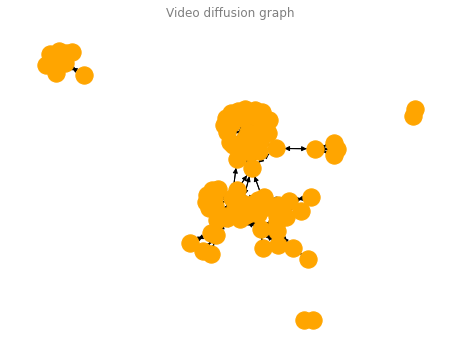

In [ ]:
# Draw the combined ego graph
plt.figure(figsize=(8, 6))
# Define positions using a layout
pos = nx.spring_layout(combined_ego_graph)

# Draw nodes
nx.draw_networkx_nodes(combined_ego_graph, pos, node_color='orange')

# Draw edges
nx.draw_networkx_edges(combined_ego_graph, pos)

# Draw node labels with transparency
labels = {node: node for node in combined_ego_graph.nodes()}
alpha_value = 0.0  # Set transparency for labels
nx.draw_networkx_labels(combined_ego_graph, pos, labels, font_size=12, font_color='black', alpha=alpha_value)

# Optionally add a title with transparency
plt.title("Video diffusion graph", alpha=0.5)  # Set transparency for title text

plt.axis('off')  # Hide axes
plt.show()

In [ ]:
# Assign colors: highlighted nodes in red, others in blue
highlight_color = "orange"
for node in combined_ego_graph.nodes():
    if node in all_nodes:
        combined_ego_graph.nodes[node]['color'] = highlight_color

nt = Network(notebook=True, font_color='#10000000')
nt.from_nx(combined_ego_graph)
nt.show("nx.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


Even with a radius set to 1, which essentially creates a graph with a depth of 1, nearly all the nodes are interconnected. This tool is incredibly effective for vividly visualizing the relationships between various research papers within the same field! You can play around with different parameters to create comprehensive graph!

<div style="color: #D5896F; font-size:120%">
Based on this graph, we can see that the paper 'MeDM: Mediating Image Diffusion Models for Video-to-Video Translation with Temporal Correspondence Guidance' is extensively interconnected. It utilizes data sources from the papers 'CelebV-HQ' and 'A Benchmark Dataset and Evaluation Methodology for Video Object Segmentation.' This paper employs the point tracking method presented in 'TAPIR: Tracking Any Point with Per-Frame...,' which is based on 'Video Diffusion Models.' These two papers share another common link through the paper 'Make-Your-Video,' which itself is based on 'Video Diffusion Models'—the same foundational paper used in 'MeDM.'

Additionally, 'Video Diffusion Models' serves as the methodological basis for numerous papers in video generation and video editing, such as 'InstructEdit', which cites 'Diffusion Probabilistic Modelling for Video Generation' and 'Dreamix'. Another example is 'StableVideo: Text-driven Consistency-aware Diffusion Video Editing', which adopts the method introduced in 'Video Diffusion Models' and focuses more on appearance editing.

There are several fascinating relationships like this to explore further within this graph. From the initial set of 15 papers, we can uncover several significant works on the topic and trace their connections!
</div>

In [ ]:
results = paper_retriever.retrieve("What are some research about transformers in vision tasks?")
all_nodes = []
for r in results:
    title = r.text.split("\n")[0]
    print(title)
    nodes = find_nodes_by_keyword(G, title)
    if len(nodes) > 0:
        all_nodes += nodes

vision transformers: state of the art and research challenges
transformers in vision: a survey
a survey on visual transformer
a survey of vision transformers in autonomous driving: current trends and future directions
transformers meet visual learning understanding: a comprehensive review
recent advances in vision transformer: a survey and outlook of recent work
what do vision transformers learn? a visual exploration
vision transformers for computer go
a survey of the vision transformers and its cnn-transformer based variants
adventures of trustworthy vision-language models: a survey
intriguing properties of vision transformers
three things everyone should know about vision transformers
flatten transformer: vision transformer using focused linear attention
gaze estimation using transformer
explainability of vision transformers: a comprehensive review and new perspectives


In [ ]:
all_nodes

['transformers in vision: a survey',
 'a survey on visual transformer',
 ') recent advances in vision transformer: a survey and outlook of recent work islam ma',
 'what do vision transformers learn? a visual exploration',
 'A survey of the Vision Transformers and its CNN-Transformer based Variants',
 'intriguing properties of vision transformers',
 'three things everyone should know about vision transformers',
 'FLatten Transformer: Vision Transformer using Focused Linear Attention',
 'gaze estimation using transformer']

In [ ]:
from matplotlib import pyplot as plt
# Generate ego graphs
ego_graphs = [nx.ego_graph(G, node, radius=1) for node in all_nodes]

# Combine all ego graphs into one graph
combined_ego_graph = nx.compose_all(ego_graphs)
# nodes_to_remove = [node for node in combined_ego_graph if combined_ego_graph.degree(node) < 2]

# Remove the nodes from the ego graph
# combined_ego_graph.remove_nodes_from(nodes_to_remove)

In [ ]:
# Assign colors: highlighted nodes in red, others in blue
highlight_color = "orange"
for node in combined_ego_graph.nodes():
    if node in all_nodes:
        combined_ego_graph.nodes[node]['color'] = highlight_color

nt = Network(notebook=True, font_color='#10000000')
nt.from_nx(combined_ego_graph)
nt.show("nx.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [ ]:
results = paper_retriever.retrieve("Give me some papers about generative pretrained transformers")
all_nodes = []
for r in results:
    title = r.text.split("\n")[0]
    print(title)
    nodes = find_nodes_by_keyword(G, title)
    if len(nodes) > 0:
        all_nodes += nodes

# Generate ego graphs
ego_graphs = [nx.ego_graph(G, node, radius=1) for node in all_nodes]

# Combine all ego graphs into one graph
combined_ego_graph = nx.compose_all(ego_graphs)
# nodes_to_remove = [node for node in combined_ego_graph if combined_ego_graph.degree(node) < 2]

# Remove the nodes from the ego graph
# combined_ego_graph.remove_nodes_from(nodes_to_remove)
# Assign colors: highlighted nodes in red, others in blue
highlight_color = "orange"
for node in combined_ego_graph.nodes():
    if node in all_nodes:
        combined_ego_graph.nodes[node]['color'] = highlight_color

nt = Network(notebook=True, font_color='#10000000')
nt.from_nx(combined_ego_graph)
nt.show("nx.html")

effective pre-training objectives for transformer-based autoencoders
don't sweep your learning rate under the rug: a closer look at cross-modal transfer of pretrained transformers
generative pre-trained transformer for design concept generation: an exploration
transformer models: an introduction and catalog
learning to grow pretrained models for efficient transformer training
model-generated pretraining signals improves zero-shot generalization of text-to-text transformers
subformer: exploring weight sharing for parameter efficiency in generative transformers
adding recurrence to pretrained transformers for improved efficiency and context size
an introduction to transformers
efficient pre-training objectives for transformers
pretrained transformers as universal computation engines
huggingface's transformers: state-of-the-art natural language processing
opt: open pre-trained transformer language models
are pre-trained convolutions better than pre-trained transformers?
birth of a transfo

In [ ]:
# results = paper_retriever.retrieve("Give me some papers about multimodal large language model?")
# all_nodes = []
# for r in results:
#     title = r.text.split("\n")[0]
#     print(title)
#     nodes = find_nodes_by_keyword(G, title)
#     if len(nodes) > 0:
#         all_nodes += nodes

# # Generate ego graphs
# ego_graphs = [nx.ego_graph(G, node, radius=1) for node in all_nodes]

# # Combine all ego graphs into one graph
# combined_ego_graph = nx.compose_all(ego_graphs)
# # nodes_to_remove = [node for node in combined_ego_graph if combined_ego_graph.degree(node) < 2]

# # Remove the nodes from the ego graph
# # combined_ego_graph.remove_nodes_from(nodes_to_remove)
# # Assign colors: highlighted nodes in red, others in blue
# highlight_color = "orange"
# for node in combined_ego_graph.nodes():
#     if node in all_nodes:
#         combined_ego_graph.nodes[node]['color'] = highlight_color

# nt = Network(notebook=True, font_color='#10000000')
# nt.from_nx(combined_ego_graph)
# nt.show("nx.html")

## **2.4 Building Graph Query Engine**

The graph query mechanism is designed to efficiently process user queries by leveraging LLM to retrieve information from a graph database. Here's a detailed breakdown of the process:

- Query Parsing: Initially, when a user submits a query, the LLM parses the query to extract key elements, typically in the form of (paper_title, relationship) pairs.

- Graph Database Querying: Once the necessary information is extracted, the next step involves querying the graph database. The process begins with locating the node corresponding to the 'paper_title'.

- Connection Edge Retrieval: After identifying the relevant paper node, the system then searches for connection edges. It specifically looks for the edge that has the highest similarity score with the extracted 'relationship' text, using a vector search. This step ensures that the most relevant connections based on the user's query are identified.

- Result Compilation: The final step involves returning the retrieved information to the LLM. The LLM then uses this data to generate a comprehensive answer tailored to the user's query, providing insights based on the connections and data found in the graph database.

For a more visual understanding of this process, refer to the diagram below,

In [ ]:
Image("/kaggle/input/gemmarag-figures/Graph-Mechanism.jpg")

### **2.4.1 Prepare data**

In [ ]:
len(relationships_dict.keys())

135

In [ ]:
relationships_prompt = {
    "Supporting Evidence": "The paper \"{source}\" provides supporting evidence for the paper \"{target}\". \nExplanation: {explanation}",
    "Is Evidence For": "The paper \"{source}\" is supported by the paper \"{target}\". \nExplanation: {explanation}",
    "Methodological Basis": "The paper \"{source}\" is a methodological basis for the paper \"{target}\". \nExplanation: {explanation}",
    "Is Methodological Basis For": "The paper \"{source}\" is based on the methodology of the paper \"{target}\". \nExplanation: {explanation}",
    "Theoretical Foundation": "The paper \"{source}\" is a theoretical foundation for the paper \"{target}\". \nExplanation: {explanation}",
    "Is Theoretical Foundation For": "The paper \"{source}\" is based on the theoretical foundation of the paper \"{target}\". \nExplanation: {explanation}",
    "Data Source": "The paper \"{source}\" uses the data from the paper \"{target}\". \nExplanation: {explanation}",
    "Is Data Source For": "The paper \"{source}\" provides data for the paper \"{target}\". \nExplanation: {explanation}",
    "Extension or Continuation": "The paper \"{source}\" is an extension or continuation of the paper \"{target}\". \nExplanation: {explanation}",
    "Is Extension or Continuation Of": "The paper \"{source}\" is extended or continued by the paper \"{target}\". \nExplanation: {explanation}",
    "Unk": "The relationship bewteen the 2 papers \"{source}\", \"{target}\" is unkown {explanation}"
}

In [ ]:
for key, val in relationships_dict.items():
    if key not in relationships_prompt.keys():
        relationships_prompt[key] = "The paper \"{source}\" provide " + val + " for paper \"{target}\". \nExplanation: {explanation}"
        relationships_prompt[val] = "The paper \"{source}\" is " + val + " of paper \"{target}\". \nExplanation: {explanation}"

In [ ]:
print(relationships_prompt['Evaluation Protocol'])

The paper "{source}" provide Is Evaluation Protocol Of for paper "{target}". 
Explanation: {explanation}


In [ ]:
# triplet_nodes = []

# for triplet in tqdm(triplets, total=len(triplets)):
#     text_prompt = relationships_prompt[triplet[1].category].format(source=triplet[0].title, target=triplet[2].title, explanation=triplet[1].explanation)
#     triplet_nodes.append(Document(text=text_prompt, metadata={"title": triplet[0].title, "arxiv_id": triplet[0].arxiv_id}))

# triplet_nodes[:3]

Now we extract the embedding of the relationships between nodes. Again, this process takes quite long so I have precomputed it. You can run the below code to extract the embedding from scratch

In [ ]:
# ## Extract embedding for the truplets relationships
# Settings.llm = None
# # Create embed model
# device_type = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5", cache_folder="../models", device=device_type)

# chroma_client = chromadb.PersistentClient(path="../DB/graph")
# chroma_collection = chroma_client.get_or_create_collection("gemma_assistant_graph")

# vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
# storage_context = StorageContext.from_defaults(vector_store=vector_store)

# index = VectorStoreIndex.from_documents(
#     triplet_nodes, storage_context=storage_context, embed_model=embed_model, show_progress=True
# )

Now, we load the relationship from the vector store

In [ ]:
from llama_index.core import VectorStoreIndex, Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext
import torch


Settings.llm = None # Set this to none to make the index only do retrieval
# device_type = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5") # must be the same as the previous stage

chroma_client = chromadb.PersistentClient(path="/home/mahita/fyp/input/graph")
chroma_collection = chroma_client.get_or_create_collection("gemma_assistant_graph")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
# load the vectorstore
storage_context = StorageContext.from_defaults(vector_store=vector_store)
rel_index = VectorStoreIndex.from_vector_store(vector_store, storage_context=storage_context, embed_model=embed_model)

LLM is explicitly disabled. Using MockLLM.


In [ ]:
from llama_index.core.vector_stores.types import MetadataFilters, ExactMatchFilter


filters = MetadataFilters(filters=[
    ExactMatchFilter(
        key="title",
        value="active learning with statistical models"
    )
])

In [ ]:
graph_rel_query_engine = rel_index.as_retriever(
    similarity_top_k=10,
    filters=filters
)

In [ ]:
retrieved_res = graph_rel_query_engine.retrieve("is based on the methodology of the paper")

In [ ]:
retrieved_res

### **2.4.2 Building the search logic**

In [ ]:
import json
import os
from typing import Any, Dict, List, Optional
from dataclasses import dataclass, field
from dataclasses_json import DataClassJsonMixin
from collections import defaultdict

import fsspec
from llama_index.core.graph_stores.types import (
    DEFAULT_PERSIST_DIR,
    DEFAULT_PERSIST_FNAME,
    GraphStore,
)
import ast
import fsspec
import logging
logger = logging.getLogger(__name__)


DEFAULT_PERSIST_DIR = "../DB/citation_graph"
DEFAULT_PERSIST_FNAME = "graph_store.json"


class CitationGraphStoreData(DataClassJsonMixin):

    """Simple Graph Store Data container.

    Args:
        graph_dict (Optional[dict]): dict mapping subject to
    """

    graph_dict: Dict[str, List[List[str]]] = defaultdict(list)
    graph_index: VectorStoreIndex = rel_index


    def find_nodes_by_keyword(self, keyword):
        """
        Find all nodes that contain the given keyword in their name.
        """
        keyword = keyword.lower()  # Convert keyword to lowercase for case-insensitive matching
        return [node for node in self.graph_dict.keys() if keyword in node.title.lower()]


    def get_rel_map(
        self, subjs: Optional[List[str]] = None, depth: int = 2, limit: int = 30
    ) -> Dict[str, List[List[str]]]:
        """Get subjects' rel map in max depth."""
        if subjs is None:
            subjs = list(self.graph_dict.keys())
        rel_map = {}
        for subj in subjs:
            rel_map[subj] = self._get_rel_map(subj.title, depth=depth, limit=limit)
        # TBD, truncate the rel_map in a spread way, now just truncate based
        # on iteration order
        rel_count = 0
        return_map = {}
        for subj in rel_map:
            if rel_count + len(rel_map[subj]) > limit:
                return_map[subj] = rel_map[subj][: limit - rel_count]
                break
            else:
                return_map[subj] = rel_map[subj]
                rel_count += len(rel_map[subj])
        return return_map

    def _get_rel_map(
        self, keyword: str, depth: int = 2, limit: int = 30
    ) -> List[List[str]]:
        """Get one subect's rel map in max depth."""
        if depth == 0:
            return []
        rel_map = []
        rel_count = 0
        subjs = self.find_nodes_by_keyword(keyword)

        if len(subjs) > 0:
            subj = subjs[0]
            for rel, obj in self.graph_dict[subj]:
                if rel_count >= limit:
                    break
                rel_map.append([subj, rel, obj])
                rel_map += self._get_rel_map(obj, depth=depth - 1)
                rel_count += 1
        return rel_map

    def search_vector(self, queries):
        # Example string that represents a tuple
        final_res = []
        for query_tuple in queries:

            # Converting string to tuple
            # result_tuple = ast.literal_eval(query_str)
            qr_title = query_tuple[0]
            qr_rel = query_tuple[1]
            nodes = self.find_nodes_by_keyword(qr_title)
            if len(nodes) == 0:
                return None
            node = nodes[0]

            filters = MetadataFilters(filters=[
                ExactMatchFilter(
                    key="title",
                    value=node.title
                )
            ])
            retriever = self.graph_index.as_retriever(
                similarity_top_k=3,
                filters=filters
            )
            res = retriever.retrieve(qr_rel)
            final_res += [r.text for r in res]

        return final_res

In [ ]:
class CitationGraphStore(GraphStore):
    """Simple Graph Store.

    In this graph store, triplets are stored within a simple, in-memory dictionary.

    Args:
        simple_graph_store_data_dict (Optional[dict]): data dict
            containing the triplets. See SimpleGraphStoreData
            for more details.
    """

    def __init__(
        self,
        data: Optional[CitationGraphStoreData] = None,
        fs: Optional[fsspec.AbstractFileSystem] = None,
        **kwargs: Any,
    ) -> None:
        """Initialize params."""
        self._data = data or CitationGraphStoreData()
        self._fs = fs or fsspec.filesystem("file")

    @classmethod
    def from_persist_dir(
        cls,
        persist_dir: str = DEFAULT_PERSIST_DIR,
        fs: Optional[fsspec.AbstractFileSystem] = None,
    ) -> "CitationGraphStore":
        """Load from persist dir."""
        persist_path = os.path.join(persist_dir, DEFAULT_PERSIST_FNAME)
        return cls.from_persist_path(persist_path, fs=fs)

    @property
    def client(self) -> None:
        """Get client.
        Not applicable for this store.
        """
        return

    def get(self, subj: str) -> List[List[str]]:
        """Get triplets."""
        return self._data.graph_dict.get(subj, [])

    def get_rel_map(
        self, subjs: Optional[List[str]] = None, depth: int = 2, limit: int = 30
    ) -> Dict[str, List[List[str]]]:
        """Get depth-aware rel map."""
        return self._data.get_rel_map(subjs=subjs, depth=depth, limit=limit)

    def upsert_triplet(self, subj: str, rel: str, obj: str) -> None:
        """Add triplet."""
        if subj not in self._data.graph_dict:
            self._data.graph_dict[subj] = []
        if (rel, obj) not in self._data.graph_dict[subj]:
            self._data.graph_dict[subj].append([rel, obj])

    def delete(self, subj: str, rel: str, obj: str) -> None:
        """Delete triplet."""
        if subj in self._data.graph_dict:
            if (rel, obj) in self._data.graph_dict[subj]:
                self._data.graph_dict[subj].remove([rel, obj])
                if len(self._data.graph_dict[subj]) == 0:
                    del self._data.graph_dict[subj]

    def persist(
        self,
        persist_path: str = os.path.join(DEFAULT_PERSIST_DIR, DEFAULT_PERSIST_FNAME),
        fs: Optional[fsspec.AbstractFileSystem] = None,
    ) -> None:
        """Persist the SimpleGraphStore to a directory."""
        fs = fs or self._fs
        dirpath = os.path.dirname(persist_path)
        if not fs.exists(dirpath):
            fs.makedirs(dirpath)

        with fs.open(persist_path, "w") as f:
            json.dump(self._data.to_dict(), f)

    def get_schema(self, refresh: bool = False) -> str:
        """Get schema."""
        return "CitationGraphStore"

    def query(self, query: str, param_map: Optional[Dict[str, Any]] = {}) -> Any:
        response = []

        pattern = r'\(([^)]+)\)'
        tuples = re.findall(pattern, query)

        pairs = [tuple(item.split(",")) for item in tuples]

        # relmap = self._data.get_rel_map(subjs=pairs, depth=param_map.get("depth") or 1, limit=param_map.get("limit") or 30)
        res = self._data.search_vector(pairs)

        response.append(res)
        return response

    @classmethod
    def from_persist_path(
        cls, persist_path: str, fs: Optional[fsspec.AbstractFileSystem] = None
    ) -> "CitationGraphStore":
        """Create a SimpleGraphStore from a persist directory."""
        fs = fs or fsspec.filesystem("file")
        if not fs.exists(persist_path):
            logger.warning(
                f"No existing {__name__} found at {persist_path}. "
                "Initializing a new graph_store from scratch. "
            )
            return cls()

        logger.debug(f"Loading {__name__} from {persist_path}.")
        with fs.open(persist_path, "rb") as f:
            data_dict = json.load(f)
            data = CitationGraphStoreData.from_dict(data_dict)
        return cls(data)

    @classmethod
    def from_dict(cls, save_dict: dict) -> "CitationGraphStore":
        data = CitationGraphStoreData.from_dict(save_dict)
        return cls(data)

    def to_dict(self) -> dict:
        return self._data.to_dict()

In [ ]:
citation_graph_store = CitationGraphStore()
for triplet in triplets:
    citation_graph_store.upsert_triplet(triplet[0], triplet[1], triplet[2])

In [ ]:
input_string = """Graph Store Query:
- (tune-a-video, methodological basis)
- (tune-a-video, data sources)"""

temp_res = citation_graph_store.query(input_string)

In [ ]:
temp_res

In [ ]:
type(temp_res)

In [ ]:
len(temp_res)

In [ ]:
from llama_index.core.query_engine import KnowledgeGraphQueryEngine
from llama_index.core import PromptTemplate
from llama_index.core.prompts.prompt_type import PromptType


QUERY_KEYWORD_EXTRACT_TEMPLATE_TMPL = (
    "A question is provided below. Given the question, extract all the (paper, relationship) pars"
    "from the text. Focus on extracting the keywords that we can use "
    "to best lookup answers to the question. Avoid stopwords.\n"
    "Example: (vq-vae, continuation), (video diffusion models, data source)"
    "---------------------\n"
    "{query_str}\n"
    "---------------------\n"
    "Provide pairs in the following comma-separated format: "
    "Example 1: (('paper name', 'relationship'), ('paper name 2', 'relationship2')) \n"
    "Example 2: (('paper name', 'relationship'))\n"
)

QUERY_KEYWORD_EXTRACT_TEMPLATE = PromptTemplate(
    QUERY_KEYWORD_EXTRACT_TEMPLATE_TMPL,
    prompt_type=PromptType.QUERY_KEYWORD_EXTRACT,
)

storage_context = StorageContext.from_defaults(graph_store=citation_graph_store)

graph_query_engine = KnowledgeGraphQueryEngine(
    storage_context=storage_context,
    graph_query_synthesis_prompt=QUERY_KEYWORD_EXTRACT_TEMPLATE,
    llm=groq_llm,
    verbose=True)

In [ ]:
Markdown(graph_query_engine.query("what are the methodological basis and data sources used in the paper 'tune-a-video'?").response)

Graph Store Query:
- (tune-a-video, methodological basis)
- (tune-a-video, data sources)
Graph Store Response:
[['The paper "tune-a-video: one-shot tuning of image diffusion models for text-to-video generation" is based on the methodology of the paper "SAVE: Spectral-Shift-Aware Adaptation of Image Diffusion Models for Text-driven Video Editing". \nExplanation: The cited works on modifying T2I diffusion models to fit the video generation process provide a methodological basis for the citing paper in text-guided video editing.; The cited work, Tune-A-Video, is used as a basis for adding temporal layers to the T2I model in the citing paper to instil temporal awareness in the video generation process.; The cited work provides a computationally efficient sparse-causal attention mechanism with O((mN ) 2 ) complexity that the citing paper uses to improve the self-attention mechanism in the T2I model and enhance the temporal coherence of video generation.', 'The paper "tune-a-video: one-shot 

Based on the provided context, the paper "tune-a-video" relies on several methodological approaches and utilizes various data sources. 

**Methodological basis:**

- **Adapting T2I diffusion models:** The paper adapts existing methods for text-to-image diffusion models to handle video generation, enhancing temporal awareness.
- **One-shot tuning:** A novel approach is proposed to fine-tune the model on a single video, eliminating the need for extensive training data.
- **Sparse causal attention:** This mechanism improves the self-attention process in the T2I model, leading to more coherent video generation.

**Data sources:**

- **TGVE competition:** Provides a dataset of videos used to evaluate the proposed method.
- **Gen-L-Video:** Offers a pipeline for generating long videos from text descriptions.
- **CoDeF:** Dataset used for obtaining video frame segmentation.
- **Dataset of pre-trained models:** Data from Wu et al. is utilized to synthesize realistic videos.

# **3. Basic Data Science Assistant**

The next part of our chatbot project involves building a Data Science bot, which will be specifically designed to assist users in navigating complex data science queries and analyses.

## **3.1 Download Wikipedia Data**

For data science questions, I will use the source from wikipedia. Wikipedia is a valuable resource for addressing data science questions due to its extensive and regularly updated content. The platform is managed by a global community of volunteers who contribute and scrutinize information, ensuring that entries are comprehensive and often cited with reliable sources. For data science topics, which can be complex and multifaceted, Wikipedia provides accessible explanations that are ideal for both beginners and professionals looking to refresh their knowledge. The articles often cover fundamental concepts, methodologies, and the historical context of topics, making it a balanced starting point for deeper research.

In [ ]:
import re

# Pre-compile the regular expression pattern for better performance
BRACES_PATTERN = re.compile(r'\{.*?\}|\}')

def remove_braces_and_content(text):
    """Remove all occurrences of curly braces and their content from the given text"""
    return BRACES_PATTERN.sub('', text)

def clean_string(input_string):
    """Clean the input string."""

    # Remove extra spaces by splitting the string by spaces and joining back together
    cleaned_string = ' '.join(input_string.split())

    # Remove consecutive carriage return characters until there are no more consecutive occurrences
    cleaned_string = re.sub(r'\r+', '\r', cleaned_string)

    # Remove all occurrences of curly braces and their content from the cleaned string
    cleaned_string = remove_braces_and_content(cleaned_string)

    # Return the cleaned string
    return cleaned_string

In [ ]:
def extract_wikipedia_pages(wiki_wiki, category_name):
    """Extract all references from a category on Wikipedia"""

    # Get the Wikipedia page corresponding to the provided category name
    category = wiki_wiki.page("Category:" + category_name)

    # Initialize an empty list to store page titles
    pages = []

    # Check if the category exists
    if category.exists():
        # Iterate through each article in the category and append its title to the list
        for article in category.categorymembers.values():
            pages.append(article.title)

    # Return the list of page titles
    return pages

In [ ]:
import wikipediaapi
from tqdm import tqdm

def get_wikipedia_pages(categories):
    """Retrieve Wikipedia pages from a list of categories and extract their content"""

    # Create a Wikipedia object
    wiki_wiki = wikipediaapi.Wikipedia('Kaggle Data Science Assistant with Gemma', 'en')

    # Initialize lists to store explored categories and Wikipedia pages
    explored_categories = []
    wikipedia_pages = []

    # Iterate through each category
    print("- Processing Wikipedia categories:")
    for category_name in categories:
        print(f"\tExploring {category_name} on Wikipedia")

        # Get the Wikipedia page corresponding to the category
        category = wiki_wiki.page("Category:" + category_name)

        # Extract Wikipedia pages from the category and extend the list
        wikipedia_pages.extend(extract_wikipedia_pages(wiki_wiki, category_name))

        # Add the explored category to the list
        explored_categories.append(category_name)

    # Extract subcategories and remove duplicate categories
    categories_to_explore = [item.replace("Category:", "") for item in wikipedia_pages if "Category:" in item]
    wikipedia_pages = list(set([item for item in wikipedia_pages if "Category:" not in item]))

    # Explore subcategories recursively
    while categories_to_explore:
        category_name = categories_to_explore.pop()
        print(f"\tExploring {category_name} on Wikipedia")

        # Extract more references from the subcategory
        more_refs = extract_wikipedia_pages(wiki_wiki, category_name)

        # Iterate through the references
        for ref in more_refs:
            # Check if the reference is a category
            if "Category:" in ref:
                new_category = ref.replace("Category:", "")
                # Add the new category to the explored categories list
                if new_category not in explored_categories:
                    explored_categories.append(new_category)
            else:
                # Add the reference to the Wikipedia pages list
                if ref not in wikipedia_pages:
                    wikipedia_pages.append(ref)

    # Initialize a list to store extracted texts
    extracted_texts = []

    # Iterate through each Wikipedia page
    print("- Processing Wikipedia pages:")
    for page_title in tqdm(wikipedia_pages, total=len(wikipedia_pages)):
        # Get the Wikipedia page
        page = wiki_wiki.page(page_title)

        # Append the page title and summary to the extracted texts list
        if len(page.summary) > len(page.title):
            extracted_texts.append(page.title + " : " + clean_string(page.summary))

        # Iterate through the sections in the page
        for section in page.sections:
            # Append the page title and section text to the extracted texts list
            if len(section.text) > len(page.title):
                extracted_texts.append(page.title + " : " + clean_string(section.text))

    # Return the extracted texts
    return extracted_texts

In [ ]:
categories = ["Computer security", "Data_science"]
extracted_texts = get_wikipedia_pages(categories)
print("Found", len(extracted_texts), "Wikipedia pages")

- Processing Wikipedia categories:
	Exploring Computer security on Wikipedia
	Exploring Data_science on Wikipedia
	Exploring Data scientists on Wikipedia
	Exploring Computer security stubs on Wikipedia
	Exploring Works about computer security on Wikipedia
	Exploring Trusted computing on Wikipedia
	Exploring Computer security standards on Wikipedia
	Exploring Software obfuscation on Wikipedia
	Exploring Computer security software on Wikipedia
	Exploring Security vulnerability databases on Wikipedia
	Exploring Computer security qualifications on Wikipedia
	Exploring Computer security procedures on Wikipedia
	Exploring Information privacy on Wikipedia
	Exploring People associated with computer security on Wikipedia
	Exploring Computer security organizations on Wikipedia
	Exploring Computer network security on Wikipedia
	Exploring Computer security models on Wikipedia
	Exploring Mobile security on Wikipedia
	Exploring IT risk management on Wikipedia
	Exploring Internet leaks on Wikipedia
	

100%|███████████████████████████████████████| 1912/1912 [10:23<00:00,  3.07it/s]

Found 8776 Wikipedia pages


In [ ]:
from llama_index.core import Document

wiki_documents = [Document(text=extracted_text, doc_id=str(i)) for i, extracted_text in enumerate(extracted_texts)]

In [ ]:
from llama_index.core import VectorStoreIndex, Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext
import torch

In [ ]:

Settings.llm = None # Set this to none to make the index only do retrieval

LLM is explicitly disabled. Using MockLLM.


In [ ]:
# !pip install protobuf==3.19.0

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.9 MB/s eta 0:00:00 0:00:01
DEPRECATION: torch-tensorrt 1.1.0a0 has a non-standard dependency specifier torch>=1.10.0+cu113<1.11.0. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torch-tensorrt or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.3
    Uninstalling protobuf-4.25.3:
      Successfully uninstalled protobuf-4.25.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.0a0+293.g0930f712e6 requires numba>=0.53.1, but you have numba 0.53.0 which is incompatible.
googlea

In [ ]:
# from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# # loads BAAI/bge-small-en
# # embed_model = HuggingFaceEmbedding()

# # loads BAAI/bge-small-en-v1.5
# embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/opt/conda/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always r

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
chroma_client = chromadb.PersistentClient(path="/home/mahita/fyp/input/wiki")
chroma_collection = chroma_client.get_or_create_collection("wiki_assitant")

# Create vector store
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

In [ ]:
index = VectorStoreIndex.from_documents(
    wiki_documents, storage_context=storage_context, embed_model=embed_model, show_progress=True
)

## **3.2 Loading from vector store**

In [ ]:
from llama_index.core import VectorStoreIndex, Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core import StorageContext
import torch


Settings.llm = None # Set this to none to make the index only do retrieval
device_type = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5", cache_folder="../models", device=device_type) # must be the same as the previous stage

chroma_client = chromadb.PersistentClient(path="/home/mahita/fyp/input/wiki")
chroma_collection = chroma_client.get_or_create_collection("wiki_assistant")
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
# load the vectorstore
storage_context = StorageContext.from_defaults(vector_store=vector_store)
ds_index = VectorStoreIndex.from_vector_store(vector_store, storage_context=storage_context, embed_model=embed_model)


In [ ]:
data_science_query_engine = ds_index.as_query_engine(
    similarity_top_k=5,
)

In [ ]:
print(data_science_query_engine.query("What is machine learning"))

## **3.3 Adding a reranker**

Adding a reranker could be beneficial for this task, as the retrieved results often include noise and unrelated context, which can complicate the generation process. But what is a reranker, and how are they different from normal retriever?

When a retriever pulls information from the vector store, it's a bit like casting a wide net – you end up with a lot of catches, but not all of them are the fish you're after. Some pieces of context can be way off the mark, leading us down the wrong path. That's where reranking comes into play. Think of reranking as a second round of scrutiny, a fine-tuning of sorts. After the initial haul from the vector search, reranking steps in to sift through the catch, reorganizing the order or ranking of the items (in this case, the documents we've retrieved) based on more specific criteria. It's like making sure the best, most relevant pieces of information are right at the top, ready for us to use. This extra step helps ensure that what we're working with is as relevant and useful as possible.

But how are rerankers different from our initial retriever?

In [ ]:
Image("/kaggle/input/gemmarag-figures/biencoder.png")

The conventional embedding model adheres to the Bi-Encoder paradigm, wherein embeddings for source documents are precomputed. During the query phase, the model generates an embedding for the user's query and then calculates the Cosine Similarity score across our database to identify the most relevant documents.

For the reranking process, it is essential to input both the source documents and the query concurrently into the model. This allows the model to evaluate the similarity between the two entities. This approach can be considerably time-intensive, as it lacks the advantage of precomputed data. However, the potential for enhanced accuracy is substantial. Therefore, the reranking process is reserved for the top documents initially retrieved by the Bi-Encoder, ensuring a balance between efficiency and precision in the document selection process.

**Reranking Cheatsheet**: Here is a useful reranking cheatsheet, originally in this [tweet](https://twitter.com/bclavie/status/1765312881120153659/photo/1). Thanks [@bclavie](https://twitter.com/bclavie)

In [ ]:
Image("/kaggle/input/gemmarag-figures/GH-ms_HWcAEYWou.jpeg")

In [ ]:
from llama_index.core.postprocessor import SentenceTransformerRerank

rerank_postprocessor = SentenceTransformerRerank(
    model='mixedbread-ai/mxbai-rerank-xsmall-v1',
    top_n=3, # number of nodes after re-ranking,
    keep_retrieval_score=True
)

In [ ]:
# re-define our query engine
data_science_query_engine = ds_index.as_query_engine(
    similarity_top_k=10,
    llm=None,
    node_postprocessors=[rerank_postprocessor],
)

In [ ]:
from llama_index.core import ChatPromptTemplate, PromptTemplate
from llama_index.core.llms import ChatMessage, MessageRole

# system_prompt = """
# You are an expert data science Q&A system
# Answer the query using the provided context information, use prior knowledge if needed.
# Some rules to follow:
# 1. Never directly reference the given context in your answer.
# 2. Avoid statements like 'Based on the context, ...' or 'The context information ...' or anything along those lines.

# """

system_prompt = """
You are an expert data science Q&A system
Answer the query using the provided context information, use prior knowledge if needed.

"""

user_prompt = """
Context information is below.
---------------------
{context_str}
---------------------
Given the context information, answer the data science question, use prior knowledge if needed.
Query: {query_str}
Answer:
"""

message_template = [
    ChatMessage(content=system_prompt, role=MessageRole.SYSTEM),
    ChatMessage(content=user_prompt, role=MessageRole.USER)
]
chat_prompt = ChatPromptTemplate(message_templates=message_template)

data_science_query_engine.update_prompts(
    {"response_synthesizer:text_qa_template": chat_prompt}
)

In [ ]:
print(data_science_query_engine.query("Tell me about machine learning"))

In [ ]:
# # re-define our query engine
# data_science_query_engine = ds_index.as_query_engine(
#     similarity_top_k=10,
#     llm=groq_llm,
#     node_postprocessors=[rerank_postprocessor],
# )

# data_science_query_engine.update_prompts(
#     {"response_synthesizer:text_qa_template": chat_prompt}
# )
# print(data_science_query_engine.query("Tell me about machine learning"))

### Citation Query Engine

In [ ]:
from llama_index.core.query_engine import CitationQueryEngine

In [ ]:
citation_query_engine = CitationQueryEngine.from_args(
    ds_index,
    similarity_top_k=3,
    # here we can control how granular citation sources are, the default is 512
    citation_chunk_size=1024,
#     llm=groq_llm,
    node_postprocessors=[rerank_postprocessor],
)

In [ ]:
print(citation_query_engine.query("Tell me about machine learning"))

# **4. Python Code Assistant**

To handle coding questions, we need a specialized Large Language Model (LLM) designed for programming. Google recently launched CodeGemma, a coding-specific LLM available in two versions: a 2 billion and a 7 billion parameter model. Let’s explore how CodeGemma can help us tackle complex coding challenges more effectively. Whether you're a beginner or an experienced developer, this tool could be a valuable addition to our toolkit.

## **4.1 Loading the CodeGemma LLM**

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/codegemma-7b-it-bnb-4bit", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

2024-05-12 21:14:34.201928: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 21:14:34.202057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 21:14:34.365617: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Gemma patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.25.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.57G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.5k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/555 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

In [ ]:
from llama_index.llms.huggingface import HuggingFaceLLM

max_seq_length = 1024 # Choose any! We auto support RoPE Scaling internally!
code_llm = HuggingFaceLLM(model=model, tokenizer=tokenizer, context_window=2048, max_new_tokens=max_seq_length)

/opt/conda/lib/python3.10/site-packages/pydantic/_internal/_fields.py:151: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


## **4.2 Define a code Assistant**

In [ ]:
from llama_index.core.query_engine import CustomQueryEngine
from llama_index.core import PromptTemplate

code_qa_prompt = PromptTemplate(
    "You are a code assistant powered by a large language model. "
    "Your task is to help users solve programming problems, provide code examples, "
    "explain programming concepts, and debug code. "
    "Write python code to answer the question bellow\n"
    "---------------------\n"
    "{query_str}\n"
    "---------------------\n"
    "Answer: "
)

class CodeQueryEngine(CustomQueryEngine):
    llm: HuggingFaceLLM
    qa_prompt: PromptTemplate
    def custom_query(self , query_str: str):
        response = self.llm.complete(
            self.qa_prompt.format(query_str=query_str)
        )
#         program = extract_program(output.text)
#         executor = PythonExecutor(get_answer_from_stdout=True)

#         exe_result = executor.apply(program)
#         response = response.text + f"\n\n**Execution Output**:```output\n\n{exe_result[0]}\n\n```\n"
        return str(response)

In [ ]:
code_query_engine = CodeQueryEngine(llm = code_llm, qa_prompt=code_qa_prompt)

In [ ]:

Markdown(code_query_engine.query("Give me code for a basic training loop in pytorch").response)



```python
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model
model = nn.Linear(10, 1)

# Define the loss function
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters())

# Training loop
for epoch in range(num_epochs):
    for batch in data_loader:
        # Get the input and target data
        inputs, targets = batch

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = loss_fn(outputs, targets)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

# Print the training loss
print(f"Epoch {epoch+1}: {loss.item()}")
```

In [ ]:
Markdown(code_query_engine.query("Give me a binary search code").response)



```python
def binary_search(arr, x):
    low = 0
    high = len(arr) - 1
    mid = 0
    
    while low <= high:
        mid = (high + low) // 2
        
        if arr[mid] == x:
            return mid
        elif arr[mid] < x:
            low = mid + 1
        else:
            high = mid - 1
    
    return -1

# Test array
arr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
x = 10

# Function call
result = binary_search(arr, x)

# Print result
if result != -1:
    print("Element is present at index", str(result))
else:
    print("Element is not present in array")
```

In [ ]:
Markdown(code_query_engine.query("How can I define a dataset class in pytorch?").response)



```python
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]
```

# **5. Combine all of them together**

How can we combine all of the tools together? The answer is by using the Router Engine. The Router Engine effectively combines various AI tools to address complex tasks. At the core of this engine is a LLM, the LLM assesses the context and specific requirements of a task to determine which AI tool is best suited for the job. This intelligent selection process ensures that the most appropriate resources are utilized, enhancing the efficiency and accuracy of the outputs. By integrating different capabilities seamlessly, the Router Engine facilitates a more dynamic and versatile approach to solving problems, streamlining workflows, and optimizing performance across diverse applications. This strategy not only maximizes the potential of individual tools but also leverages their collective strengths in a cohesive and intelligent manner.

In [ ]:
Image("/kaggle/input/gemmarag-figures/RouterEngine.jpg")

## **5.1 Define Router Engine**

In [ ]:
from llama_index.core.query_engine import RouterQueryEngine
from llama_index.core.selectors import LLMSingleSelector
from llama_index.core.tools import QueryEngineTool
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.llms.groq import Groq
# from unsloth import FastLanguageModel
import os

/opt/conda/lib/python3.8/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [ ]:
from typing import Any, Dict, List, Optional, Sequence, cast

from llama_index.core.base.base_selector import (
    BaseSelector,
    SelectorResult,
    SingleSelection,
)
from llama_index.core.output_parsers.base import StructuredOutput
from llama_index.core.output_parsers.selection import Answer, SelectionOutputParser
from llama_index.core.prompts.mixin import PromptDictType
from llama_index.core.prompts.prompt_type import PromptType
from llama_index.core.schema import QueryBundle
from llama_index.core.selectors.prompts import (
    DEFAULT_MULTI_SELECT_PROMPT_TMPL,
    DEFAULT_SINGLE_SELECT_PROMPT_TMPL,
    MultiSelectPrompt,
    SingleSelectPrompt,
)
from llama_index.core.service_context import ServiceContext
from llama_index.core.service_context_elements.llm_predictor import (
    LLMPredictorType,
)
from llama_index.core.settings import Settings, llm_from_settings_or_context
from llama_index.core.tools.types import ToolMetadata
from llama_index.core.types import BaseOutputParser


def _build_choices_text(choices: Sequence[ToolMetadata]) -> str:
    """Convert sequence of metadata to enumeration text."""
    texts: List[str] = []
    for ind, choice in enumerate(choices):
        text = " ".join(choice.description.splitlines())
        text = f"({ind + 1}) {text}"  # to one indexing
        texts.append(text)
    return "\n\n".join(texts)


def _structured_output_to_selector_result(output: Any) -> SelectorResult:
    """Convert structured output to selector result."""
    structured_output = cast(StructuredOutput, output)
    answers = cast(List[Answer], structured_output.parsed_output)

    # adjust for zero indexing
    selections = [
        SingleSelection(index=answer.choice - 1, reason=answer.reason)
        for answer in answers
    ]
    return SelectorResult(selections=selections)


class LLMSingleSelectorCustom(BaseSelector):
    """LLM single selector.

    LLM-based selector that chooses one out of many options.

    Args:
        LLM (LLM): An LLM.
        prompt (SingleSelectPrompt): A LLM prompt for selecting one out of many options.
    """

    def __init__(
        self,
        llm: LLMPredictorType,
        prompt: SingleSelectPrompt,
    ) -> None:
        self._llm = llm
        self._prompt = prompt

        if self._prompt.output_parser is None:
            raise ValueError("Prompt should have output parser.")

    @classmethod
    def from_defaults(
        cls,
        llm: Optional[LLMPredictorType] = None,
        service_context: Optional[ServiceContext] = None,
        prompt_template_str: Optional[str] = None,
        output_parser: Optional[BaseOutputParser] = None,
    ) -> "LLMSingleSelector":
        # optionally initialize defaults
        llm = llm or llm_from_settings_or_context(Settings, service_context)
        prompt_template_str = prompt_template_str or DEFAULT_SINGLE_SELECT_PROMPT_TMPL
        output_parser = output_parser or SelectionOutputParser()

        # construct prompt
        prompt = SingleSelectPrompt(
            template=prompt_template_str,
            output_parser=output_parser,
            prompt_type=PromptType.SINGLE_SELECT,
        )
        return cls(llm, prompt)

    def _get_prompts(self) -> Dict[str, Any]:
        """Get prompts."""
        return {"prompt": self._prompt}

    def _update_prompts(self, prompts: PromptDictType) -> None:
        """Update prompts."""
        if "prompt" in prompts:
            self._prompt = prompts["prompt"]

    def _select(
        self, choices: Sequence[ToolMetadata], query: QueryBundle
    ) -> SelectorResult:
        # prepare input
        choices_text = _build_choices_text(choices)

        # predict
        prediction = self._llm.predict(
            prompt=self._prompt,
            num_choices=len(choices),
            context_list=choices_text,
            query_str=query.query_str,
        )
        print(prediction)

        # parse output
        assert self._prompt.output_parser is not None
        parse = self._prompt.output_parser.parse(prediction)
        return _structured_output_to_selector_result(parse)

    async def _aselect(
        self, choices: Sequence[ToolMetadata], query: QueryBundle
    ) -> SelectorResult:
        # prepare input
        choices_text = _build_choices_text(choices)

        # predict
        prediction = await self._llm.apredict(
            prompt=self._prompt,
            num_choices=len(choices),
            context_list=choices_text,
            query_str=query.query_str,
        )

        # parse output
        assert self._prompt.output_parser is not None
        parse = self._prompt.output_parser.parse(prediction)
        return _structured_output_to_selector_result(parse)


In [ ]:
Settings.llm = Groq(model="gemma-7b-it", api_key=groq_token)

In [ ]:
paper_tool = QueryEngineTool.from_defaults(
    query_engine=paper_query_engine,
    description="Useful for search for papers",
)

graph_tool = QueryEngineTool.from_defaults(
    query_engine=graph_query_engine,
    description="Useful for answering  between papers",
)

# ds_tool = QueryEngineTool.from_defaults(
#     query_engine=data_science_query_engine,
#     description="Useful for answering data science concepts",
# )

# code_tool = QueryEngineTool.from_defaults(
#     query_engine=code_query_engine,
#     description="Useful for answering coding questions",
# )

query_engine = RouterQueryEngine(
    selector=LLMSingleSelectorCustom.from_defaults(),
    query_engine_tools=[
        paper_tool,
#         ds_tool,
        graph_tool,
#         code_tool
    ],
    verbose=True
)

In [ ]:
try:
    print(query_engine.query("How to do paper research about video diffusion?"))
except:
    pass print("404 Not Found")

In [ ]:
try:
    print(query_engine.query("Give me a code for a binary search function?"))
except:
    pass

```json
[
    {
        "choice": 1,
        "reason": "The summary states that the function is useful for answering coding questions, which aligns with the request for a binary search function code."
    }
]
```
Selecting query engine 0: The summary states that the function is useful for answering coding questions, which aligns with the request for a binary search function code..

```python
def binary_search(arr, x):
    low = 0
    high = len(arr) - 1
    mid = 0
    
    while low <= high:
        mid = (high + low) // 2
        
        if arr[mid] == x:
            return mid
        elif arr[mid] < x:
            low = mid + 1
        else:
            high = mid - 1
    
    return -1

# Test array
arr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
x = 10

# Function call
result = binary_search(arr, x)

# Print result
if result != -1:
    print("Element is present at index", str(result))
else:
    print("Element is not present in array")
```


In [ ]:
res = query_engine.query("Give me a code for a binary search function?")

```json
[
    {
        "choice": 1,
        "reason": "The summary (1) explicitly mentions usefulness for answering coding questions, which aligns with the request for a binary search function code."
    }
]
```
Selecting query engine 0: The summary (1) explicitly mentions usefulness for answering coding questions, which aligns with the request for a binary search function code..


In [ ]:
print(res.response)


```python
def binary_search(arr, x):
    low = 0
    high = len(arr) - 1
    mid = 0
    
    while low <= high:
        mid = (high + low) // 2
        
        if arr[mid] == x:
            return mid
        elif arr[mid] < x:
            low = mid + 1
        else:
            high = mid - 1
    
    return -1

# Test array
arr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
x = 10

# Function call
result = binary_search(arr, x)

# Print result
if result != -1:
    print("Element is present at index", str(result))
else:
    print("Element is not present in array")
```


In [ ]:
output =

# **Bonus Section: Building a simple UI**

In [ ]:
%%capture
!pip install --upgrade gradio

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
def query_func(message, history):

    return query_engine.query(message).response

In [ ]:
output = "I'm sarvesh"

In [ ]:
def query_func(message, history):

#     res = query_engine.query(message)
#     output = res.response
    ans = output

    return ans

In [ ]:
# msg = "Hello"
# history = "Hola"

In [ ]:
# print(query_func(msg, history))

In [ ]:
import gradio as gr

gr.ChatInterface(query_func).launch(share=True)

Running on local URL:  http://127.0.0.1:7861


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running on public URL: https://c3cdc9789fe77be447.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


```json
[
    {
        "choice": 1,
        "reason": "The first choice suggests it's relevant for searching for papers related to the research topic."
    }
]
```
Selecting query engine 0: The first choice suggests it's relevant for searching for papers related to the research topic..
```json
[
    {
        "choice": 1,
        "reason": "The first choice suggests that it is useful for searching for papers, which aligns with the question's intent of finding papers related to the topic."
    }
]
```
Selecting query engine 0: The first choice suggests that it is useful for searching for papers, which aligns with the question's intent of finding papers related to the topic..
```json
[
    {
        "choice": 1,
        "reason": "The first choice mentions usefulness for searching papers, which aligns with the question's intent of finding papers related to the topic."
    }
]
```
Selecting query engine 0: The first choice mentions usefulness for searching papers, which aligns with the q